In [1]:
import math, random
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import cvxpy as cv

# Gene Expression model

A gene can either be on or off, in the on state a molecule M can be created, M degrades regardless of the gene state:

$ G_{off} \underset{k_{off}}{\stackrel{k_{on}}{\rightleftharpoons}} G_{on} $

$ G_{on} \stackrel{k_{tx}}\longrightarrow G_{on} + M $

$ M \stackrel{k_{deg}}\longrightarrow \varnothing $

However, in practice we can only observe the state/number of molecules M, not the state of gene expression:

We observe the marginal $\bar{p}(m)$ and not $p(m,0)$ or $p(m,1)$

State space:

$ (m,g) \in \mathbb{N} \times \{0,1\} $ where g = 0 corresponds to $ G_{off} $ and g = 1 to $ G_{on} $

# Simulation

First we need to simulate paths of the model, so long term averages to approximate the stationary distribution can be found

Use Gillespie to simulate exponential holding times, and transition probabilities given reaction rates:

In [2]:
def sample_path_gene(initial_state, params, tmax, plot=False):
    """
    Simulate a sample path of gene expression
    start at initial state, run until time tmax, rates in params
    return visited states and jump times
    """

    # initialise time and state (also store jump times)
    t = 0
    path = [(initial_state[0],initial_state[1])]
    jump_times = [0]
    k_on, k_off, k_tx, k_deg = params[0], params[1], params[2], params[3]

    # simulate until stopping time
    while t < tmax:
        # simulate holding time of current state (m,g)
        m, g = path[-1][0], path[-1][1]

        # define rates
        # q(x,x+(0,1)): gene turns on if off
        q_on = (1 - g) * k_on
        # q(x,x+(0,-1)): gene turns off if on
        q_off = g * k_off
        # q(x,x+(1,0)): transscription if gene on
        q_tx = g * k_tx
        # q(x,x+(-1,0)): degradation if  there are molecules
        q_deg = m * k_deg
        # -q(x,x): holding rate = sum q(x,y) over y
        q_hold = q_on + q_off + q_tx + q_deg

        # exponential holding time of state
        t_hold = -math.log(random.random()) / q_hold
        t += t_hold
        jump_times.append(t)

        # jump probability
        # P(x -> y) = q_xy / q_hold
        outcome = [1,2,3,4]
        prob = [q_on / q_hold, q_off / q_hold, q_tx / q_hold, q_deg / q_hold]
        jump = np.random.choice(outcome,p=prob)
        # jump to new state
        if jump == 1:
            path.append((m,g + 1))
        elif jump == 2:
            path.append((m,g - 1))
        elif jump == 3:
            path.append((m + 1,g))
        elif jump == 4:
            path.append((m - 1,g))

    if plot:
        # separate paths
        m_path = [state[0] for state in path]
        g_path = [state[1] for state in path]
        plt.scatter(jump_times, m_path, c=g_path, ec='k')

        # defined colour plotting
        #cmap, norm = mcolors.from_levels_and_colors([0, 1, 2], ['orange','blue'])
        #plt.scatter(jump_times, m_list, c=g_list, cmap=cmap, norm=norm)

    return path, jump_times

Short example path to check:
- yellow <=> gene on
- purple <=> gene off
- only increases m when gene on, constant decrease regardless of gene

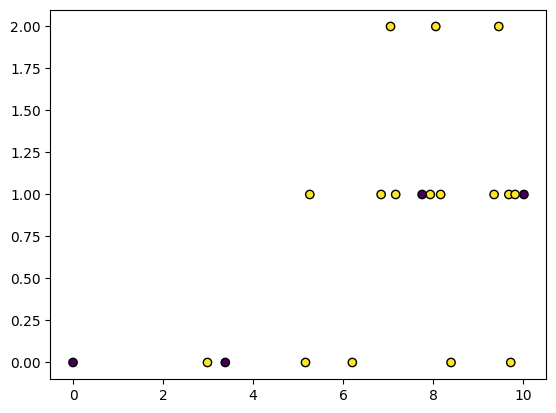

In [3]:
path, jump = sample_path_gene([0,0],[1,1,1,1],10,plot=True)

# Bootstrapping

Method:
- simulate path up to time t (sufficiently large for stationarity behaviour)
- record final state (a sample from the stationary distribution)
- repeat for n samples

bootstrapping:
- sample with replacement to obtain N bootstrap samples from the n values
- calculate the proportion of states x for each sample (estimate of p(x))
- find Confidence Intervals for each estimate


We first consider CIs for all states (m,g)

In [4]:
def bootstrap(x_list, initial_state, params, tmax, n, N, plot=False, printing=False):
    """
    x_list: states to calculate probabilities for
    initial state
    parameters
    tmax: time of path before sample
    n = number of simulated samples
    N = number of bootstrap samples
    """

    # simulate n samples
    states = []
    for i in range(n):
        path, jumps = sample_path_gene(initial_state, params, tmax, plot=plot)
        states.append(path[-2]) # last state before tmax
    plt.show()

    # simulate N bootstrap samples: estimates p(x) for each, and for each x
    estimates = [[] for x in x_list]
    for i in range(N):
        sample = random.choices(states,k = n)
        for i, x in enumerate(x_list):
            estimates[i].append(sample.count(x) / n)

    # create confidence intervals (95%) via 2.5%, 97.5% quantiles for each x
    intervals = [np.quantile(est,[0.025,0.975]) for est in estimates]
    
    # plot histograms and CI
    for i, x in enumerate(x_list):
        if printing:
            print(f"95% CI for p({x}) is: ({intervals[i][0]}, {intervals[i][1]})")
        if plot:
            plt.hist(estimates[i])
            plt.title(f"Hist of p({x})")
            plt.axvline(intervals[i][0], color="red")
            plt.axvline(intervals[i][1], color="red")
            plt.show()

    # return CIs
    return estimates, intervals

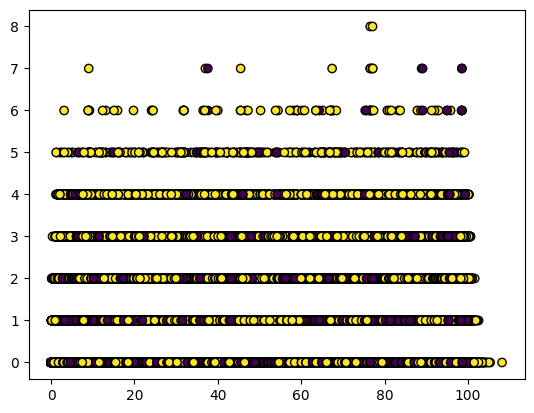

95% CI for p((0, 0)) is: (0.346, 0.405)


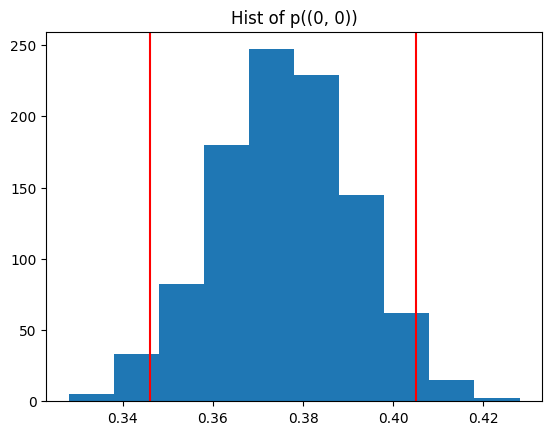

95% CI for p((0, 1)) is: (0.220975, 0.272025)


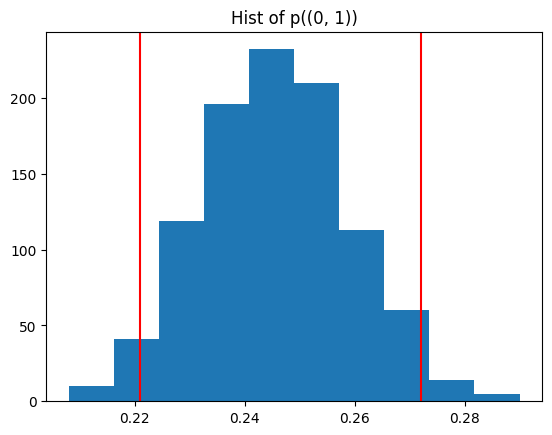

95% CI for p((1, 0)) is: (0.088, 0.127)


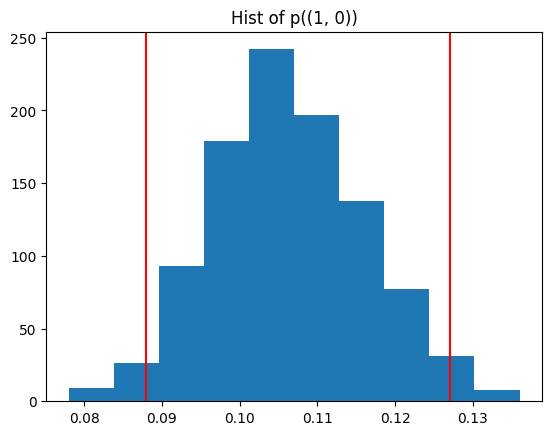

95% CI for p((1, 1)) is: (0.13897500000000002, 0.185)


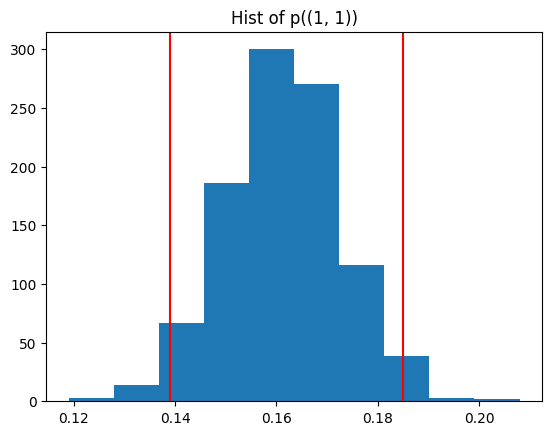

In [5]:
estimates, intervals = bootstrap([(0,0),(0,1),(1,0),(1,1)],[0,0],[1,1,1,1],100,1000,1000,plot=True,printing=True)

# Marginal

Now consider forming confidence intervals for the marginal stationary distribution of the chain, when no information on g is available.

Marginal: $ \bar{p}(m) = p(m,0) + p(m,1) $

#### Method:
- perform simuation as before, but compute estimates and CI's only over m values
- directly gives CI on marginal

In [6]:
def bootstrap_marginal(m_list, initial_state, params, tmax, n, N, plot=False, printing=False):
    """
    m_list: marginal states of m to calculate probabilities for
    initial state
    parameters
    tmax: time of path before sample
    n = number of simulated samples
    N = number of bootstrap samples
    """

    # simulate n samples: (m,g)
    states = []
    for i in range(n):
        path, jumps = sample_path_gene(initial_state, params, tmax, plot=plot)
        states.append(path[-2]) # last state before tmax
    plt.show()

    # simulate N bootstrap samples: estimates p(m) for each, and for each m
    estimates = [[] for x in m_list]
    for i in range(N):
        # sample with replacement from (m,g) samples
        sample = random.choices(states,k = n)
        # take just marginal m information
        m_sample = [state[0] for state in sample]
        # estimate p(m) from marginal info
        for i, x in enumerate(m_list):
            estimates[i].append(m_sample.count(x) / n)

    # create confidence intervals (95%) via 2.5%, 97.5% quantiles for each x
    intervals = [np.quantile(est,[0.025,0.975]) for est in estimates]
    
    # plot histograms and CI
    for i, x in enumerate(m_list):
        if printing:
            print(f"95% CI for p({x}) is: ({intervals[i][0]}, {intervals[i][1]})")
        if plot:
            plt.hist(estimates[i])
            plt.title(f"Hist of p({x})")
            plt.axvline(intervals[i][0], color="red")
            plt.axvline(intervals[i][1], color="red")
            plt.show()

    # return CIs
    return estimates, intervals

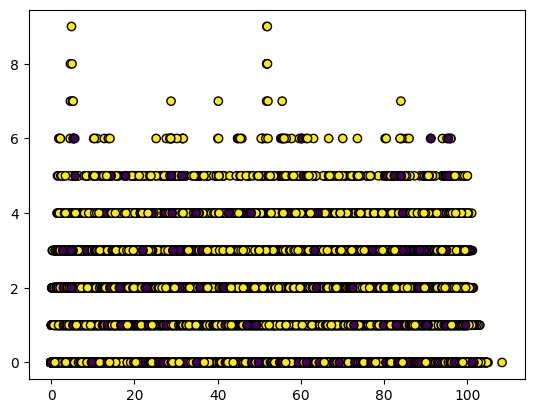

95% CI for p(0) is: (0.603, 0.664)


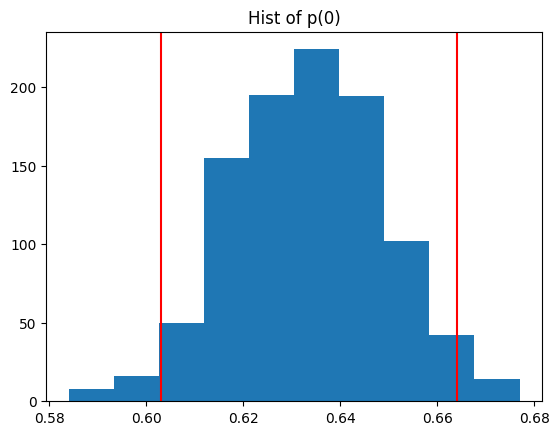

95% CI for p(1) is: (0.22, 0.275)


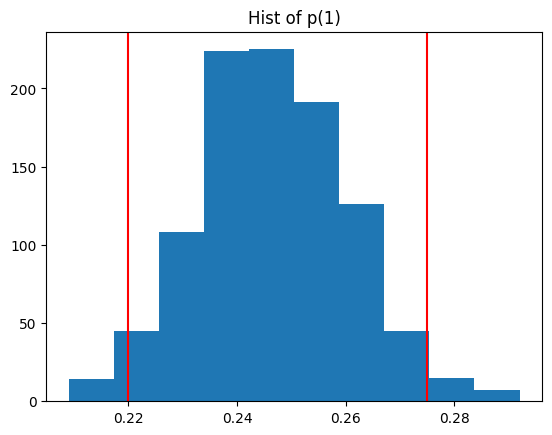

In [7]:
estimates_marginal, intervals_marginal = bootstrap_marginal([0,1],[0,0],[1,1,1,1],100,1000,1000,plot=True,printing=True)

# Linear Program

Using bootstrap confidence intervals as bounds on the stationary distribution form LPs to bound parameters

## (1) All states
- initially find bounds for each state (m,g), use all information to solve LP

In [8]:
states = [(0,0),(0,1),(1,0),(1,1),(2,0),(2,1),(3,0),(3,1),(4,0),(4,1),(5,0),(5,1),(6,0),(6,1)]
estimates_test, intervals_test = bootstrap(states,[0,0],[1,1,0.5,1],100,1000,1000,plot=False,printing=True)

95% CI for p((0, 0)) is: (0.406, 0.465)
95% CI for p((0, 1)) is: (0.317, 0.375)
95% CI for p((1, 0)) is: (0.055, 0.086)
95% CI for p((1, 1)) is: (0.093, 0.131)
95% CI for p((2, 0)) is: (0.005, 0.018)
95% CI for p((2, 1)) is: (0.016, 0.035)
95% CI for p((3, 0)) is: (0.0, 0.0)
95% CI for p((3, 1)) is: (0.0, 0.005)
95% CI for p((4, 0)) is: (0.0, 0.0)
95% CI for p((4, 1)) is: (0.0, 0.0)
95% CI for p((5, 0)) is: (0.0, 0.0)
95% CI for p((5, 1)) is: (0.0, 0.0)
95% CI for p((6, 0)) is: (0.0, 0.0)
95% CI for p((6, 1)) is: (0.0, 0.0)


In [9]:
# number of equations used (rows of Q)
N = 3

# create Qr matrices:
# create N + 2 x N + 2 square and drop last 2 rows, as have 2 upper diagonals
Q_on = (np.diag([-1 if not x % 2 else 0 for x in range(0,N+2)],0) +
        np.diag([1 if not x % 2 else 0 for x in range(0,N+1)],-1))[:-2, :]
Q_off = (np.diag([-1 if x % 2 else 0 for x in range(0,N+2)],0) +
         np.diag([1 if not x % 2 else 0 for x in range(0,N+1)],1))[:-2, :]
Q_tx = (np.diag([-1 if x % 2 else 0 for x in range(0,N+2)],0) +
        np.diag([1 if x % 2 else 0 for x in range(0,N)],-2))[:-2, :]
Q_deg = (np.diag([-1 if x > 1 else 0 for x in range(0,N+2)],0) +
         np.diag([1 for x in range(0,N)],2))[:-2, :]

# bounds from CI
pl = [intr[0] for intr in intervals_test]
pu = [intr[1] for intr in intervals_test]

# define bounds
pl = np.array(pl)[:N + 2]
pu = np.array(pu)[:N + 2]

# NOTE: truncate to N + 2, as 2 rows above diag, so Nth equation has N + 2 p's

# Construct the problem.
#k_on = cv.Variable(1)
k_on = 1
#k_off = cv.Variable(1)
k_off = 1
k_tx = cv.Variable(1)
#k_tx = 0.5
#k_deg = cv.Variable(1)
k_deg = 1
z_on = cv.Variable(N + 2)
z_off = cv.Variable(N + 2)
z_tx = cv.Variable(N + 2)
z_deg = cv.Variable(N + 2)
objective_max = cv.Maximize(k_tx)
objective_min = cv.Minimize(k_tx)
constraints = [Q_on @ z_on + Q_off @ z_off + Q_tx @ z_tx + Q_deg @ z_deg == 0,
               k_on >= 0, k_off >= 0, k_tx >= 0, k_deg >= 0,
               k_on * pl <= z_on, z_on <= k_on * pu,
               k_off * pl <= z_off, z_off <= k_off * pu,
               k_tx * pl <= z_tx, z_tx <= k_tx * pu,
               k_deg * pl <= z_deg, z_deg <= k_deg * pu,
               ]
prob_max = cv.Problem(objective_max, constraints)
prob_min = cv.Problem(objective_min, constraints)   

# Print result.
result_max = prob_max.solve()
print(prob_max.status)
print("\nThe upper bound is", prob_max.value)
print(f"k_tx: {k_tx.value}")
result_min = prob_min.solve()
print(prob_min.status)
print("\nThe lower bound is", prob_min.value)
print(f"k_tx: {k_tx.value}")

optimal

The upper bound is 0.6845425869012844
k_tx: [0.68454259]
optimal

The lower bound is 0.39466666662135014
k_tx: [0.39466667]


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


## Results:

Using k_tx = 0.5, all others fixed to 1

- Using N equations uses N + 2 p's, so after N = 3 bounds happen to be infeasible e.g. 5th p bounds may be wrong
- However, good bounds on k_tx = 0.5 after only a few equations:

N = 1: no bounds (no k_tx in first equations) \
N = 2: [0.44, 0.53] \
N = 3: [0.44, 0.51]


## (2) Marginal states

- use only bounds on states of m: $ \bar{p}(m) = p(m,0) + p(m,1) $

In [10]:
def gene_expression_LP(params, N, bounds, printing=False):
	# N = number of equations used (rows of Q)
	# NOTE: restrict to even atm (as p's enter as pairs)

	# number of marginals used
	M = int(N/2 + 1)

	# create Qr matrices:
	# create N + 2 x N + 2 square and drop last 2 rows, as have 2 upper diagonals
	Q_on = (np.diag([-1 if not x % 2 else 0 for x in range(0,N+2)],0) +
			np.diag([1 if not x % 2 else 0 for x in range(0,N+1)],-1))[:-2, :]
	Q_off = (np.diag([-1 if x % 2 else 0 for x in range(0,N+2)],0) +
			np.diag([1 if not x % 2 else 0 for x in range(0,N+1)],1))[:-2, :]
	Q_tx = (np.diag([-1 if x % 2 else 0 for x in range(0,N+2)],0) +
			np.diag([1 if x % 2 else 0 for x in range(0,N)],-2))[:-2, :]
	Q_deg = (np.diag([-1 if x > 1 else 0 for x in range(0,N+2)],0) +
			np.diag([1 for x in range(0,N)],2))[:-2, :]

	# bounds from CI, on marginal
	pl = [intr[0] for intr in bounds]
	pu = [intr[1] for intr in bounds]

	# define bounds
	pl = np.array(pl)[:M]
	pu = np.array(pu)[:M]

	# NOTE: need different cutoff: n p's <=> n/2 marginals

	# marginal = A @ p
	A = np.repeat(np.eye(M, dtype=int), repeats=2, axis=1)

	# Construct the problem.

	# Variables
	k1, k2, k3, k4 = params[0], params[1], params[2], params[3]
	if k1 == "v":
		k_on = cv.Variable(1)
	else:
		k_on = k1
	if k2 == "v":
		k_off = cv.Variable(1)
	else:
		k_off = k2
	if k3 == "v":
		k_tx = cv.Variable(1)
	else:
		k_tx = k3
	if k4 == "v":
		k_deg = cv.Variable(1)
	else:
		k_deg = k4
	z_on = cv.Variable(N + 2)
	z_off = cv.Variable(N + 2)
	z_tx = cv.Variable(N + 2)
	z_deg = cv.Variable(N + 2)

	# Objective
	var = "k_tx"
	objective_max = cv.Maximize(k_tx)
	objective_min = cv.Minimize(k_tx)

	# Constraints: Qp = 0, kr > 0, marginal bounds, joint prob in [0,1]
	constraints = [Q_on @ z_on + Q_off @ z_off + Q_tx @ z_tx + Q_deg @ z_deg == 0,
			z_on <= k_on, z_off <= k_off, z_tx <= k_tx, z_deg <= k_deg,
			#z_on >= 0.001 * k_on, z_off >= 0.001 * k_off, z_tx >= 0.001 * k_tx, z_deg >= 0.001 * k_deg,
			z_on >= 0, z_off >= 0, z_tx >= 0, z_deg >= 0,
			k_on >= 0, k_off >= 0, k_tx >= 0, k_deg >= 0,
			k_on * pl <= A @ z_on, A @ z_on <= k_on * pu,
			k_off * pl <= A @ z_off, A @ z_off <= k_off * pu,
			k_tx * pl <= A @ z_tx, A @ z_tx <= k_tx * pu,
			k_deg * pl <= A @ z_deg, A @ z_deg <= k_deg * pu,
			]

	# define
	prob_max = cv.Problem(objective_max, constraints)
	prob_min = cv.Problem(objective_min, constraints)   

	# Print results
	result_max = prob_max.solve()
	if printing:
		print(f"Upper bound status: {prob_max.status}")
		print(f"\nUpper bound on {var}: {prob_max.value}")
		print(f"\nz_on: {z_on.value}")
		print(f"z_off: {z_off.value}")
		print(f"z_tx: {z_tx.value}")
		print(f"z_deg: {z_deg.value}")

	result_min = prob_min.solve()
	if printing:
		print(f"\nLower bound status: {prob_min.status}")
		print(f"\nLower bound on {var}: {prob_min.value}")
		print(f"\nz_on: {z_on.value}")
		print(f"z_off: {z_off.value}")
		print(f"z_tx: {z_tx.value}")
		print(f"z_deg: {z_deg.value}")

	return prob_max.value, prob_min.value

In [11]:
# attempt different parameters
states = [x for x in range(10)]
estimates_marginal, intervals_marginal = bootstrap_marginal(states,[0,0],[0.8,0.2,0.5,1],100,2000,2000,plot=False,printing=True)

95% CI for p(0) is: (0.6385, 0.6815)
95% CI for p(1) is: (0.2455, 0.2840124999999999)
95% CI for p(2) is: (0.0565, 0.0785)
95% CI for p(3) is: (0.004, 0.0115)
95% CI for p(4) is: (0.0, 0.0015)
95% CI for p(5) is: (0.0, 0.0015)
95% CI for p(6) is: (0.0, 0.0)
95% CI for p(7) is: (0.0, 0.0)
95% CI for p(8) is: (0.0, 0.0)
95% CI for p(9) is: (0.0, 0.0)


In [12]:
gene_expression_LP(["v","v","v",1],8,intervals_marginal,printing=True)

Upper bound status: unbounded

Upper bound on k_tx: inf

z_on: None
z_off: None
z_tx: None
z_deg: None

Lower bound status: optimal

Lower bound on k_tx: 0.3602347761752104

z_on: [0.32597297 0.22585408 0.08457351 0.13378748 0.01848958 0.03534101
 0.00225017 0.00395653 0.00037582 0.00037582]
z_off: [0.35599435 0.23979365 0.08956191 0.14664259 0.01970023 0.03946056
 0.00257186 0.00477377 0.00040791 0.00040791]
z_tx: [-1.23324479e-11  2.45500000e-01  2.70073931e-02  6.62991747e-02
  1.40340296e-02  8.74251297e-03  1.52584415e-03  1.12112525e-03
  1.62852525e-04  1.62852525e-04]
z_deg: [0.32975156 0.32975156 0.08617932 0.15932068 0.02411024 0.04218894
 0.00313926 0.00560325 0.00061566 0.00050546]


(inf, 0.3602347761752104)

# Results

The joint probabilities (multipied be rates to get z's) only occur as sums of pairs, so had problem of taking negative values, seen by negative z's. So, enforce bounds of [0,1] on p's => bounds of [0, kr] on z's (as well as all rates kr > 0)

- These constraints allow a lower bound to be found, possibly converging to true value? (or true range of possible values given data)

However, a non-zero lower bound on p's/z's is needed for an upper bound on the LP:
- using e.g. 0.01 as a bound on p is enough, but reducing in magnitude increaes upper bound, and not rigorous (may not always be true)

# Test solution lower bound
- simulate many marginal bounds e.g. 10+
- solve LP using increasing numbers of equations/bounds
- test if lower bound of solution converges to true value of parameter (or true range given input bounds)

In [13]:
# simulate marginal bounds
states = [x for x in range(12)]
estimates_test, intervals_test = bootstrap_marginal(states,[0,0],[1,1,0.5,1],1000,20000,20000,plot=False,printing=True)

KeyboardInterrupt: 

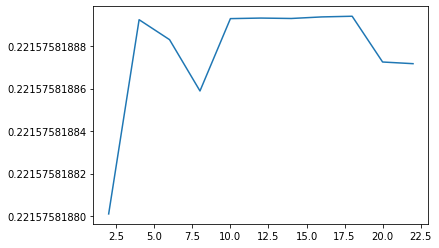

In [76]:
# increase number of equations/marginals used
equations_used = []
solution_lower = []
for N in range(2,24,2):
    # solve LP
    upper_bound, lower_bound = gene_expression_LP(["v","v","v",1],N,intervals_test)
    equations_used.append(N)
    solution_lower.append(lower_bound)
plt.ticklabel_format(useOffset=False)
plt.plot(equations_used,solution_lower)

Lower bound on k_tx doesn't seem to improve as more equations added

# Additional Constraints

Bounding joint probabilities by [0,1] allowed a lower bound on the LP, but a non-zero lower bound on p is needed for an upper bound on the LP. Using e.g. 0.01 is just an approximation, and may not be true.

### Frechet bounds:

max{0, P(X) + P(Y) - 1} < P(X n Y) < min{P(X), P(Y)}

Applying to marginals of M and G, where P(G = 1) = k_on / k_on + k_off, can bound joint probabilities:

In [14]:
# simulate marginal bounds
estimates_test, intervals_test = bootstrap_marginal([x for x in range(5)],[0,0],[0.8,0.2,0.5,1],100,1000,1000,plot=False,printing=False)
# form bound vectors (on marginal)
pl = np.array([intr[0] for intr in intervals_test])
pu = np.array([intr[1] for intr in intervals_test])
# form doubled bound vectors
pdl = np.repeat(pl,2)
pdu = np.repeat(pu,2)
# form bounds on joint probs
k1 = 0.8
k2 = 0.2
kv = [k2 if x % 2 else k1 for x in range(10)]
z1_lb = k1 * pdl + k2 * pdl - k2 * pdu - kv
z2_lb = k1 * pdl + k2 * pdl - k1 * pdu - kv
print(f"z1 lb: \n {z1_lb}")
print(f"\nz2 lb: \n {z2_lb}")
zsum_lb = (k1 + k2) * pdl - kv
print(f"\nz1 + z2 lb: \n {zsum_lb}")

z1 lb: 
 [-0.2768  0.3232 -0.6358 -0.0358 -0.7794 -0.1794 -0.7992 -0.1992 -0.8008
 -0.2008]

z2 lb: 
 [-0.7142 -0.1142 -0.8002 -0.2002 -0.8136 -0.2136 -0.8088 -0.2088 -0.8032
 -0.2032]

z1 + z2 lb: 
 [-0.131  0.469 -0.581  0.019 -0.768 -0.168 -0.796 -0.196 -0.8   -0.2  ]


See above that only a few of the lower bounds on z1 and z2 are non-negative, can cover this by still using [0,kr] bounds, but means that only a few variables will now have tighter bounds

Can also bound the sum of z1 and z2 terms

In [15]:
def gene_expression_LP_2(params, N, bounds, printing=False):
	# N = number of equations used (rows of Q)
	# NOTE: restrict to even atm (as p's enter as pairs)

	# number of marginals used
	M = int(N/2 + 1)

	# create Qr matrices:
	# create N + 2 x N + 2 square and drop last 2 rows, as have 2 upper diagonals
	Q_on = (np.diag([-1 if not x % 2 else 0 for x in range(0,N+2)],0) +
			np.diag([1 if not x % 2 else 0 for x in range(0,N+1)],-1))[:-2, :]
	Q_off = (np.diag([-1 if x % 2 else 0 for x in range(0,N+2)],0) +
			np.diag([1 if not x % 2 else 0 for x in range(0,N+1)],1))[:-2, :]
	Q_tx = (np.diag([-1 if x % 2 else 0 for x in range(0,N+2)],0) +
			np.diag([1 if x % 2 else 0 for x in range(0,N)],-2))[:-2, :]
	Q_deg = (np.diag([-1 if x > 1 else 0 for x in range(0,N+2)],0) +
			np.diag([1 for x in range(0,N)],2))[:-2, :]

	# bounds from CI, on marginal
	pl = [intr[0] for intr in bounds]
	pu = [intr[1] for intr in bounds]

	# define bounds
	pl = np.array(pl)[:M]
	pu = np.array(pu)[:M]

	# form doubled bounds
	pdl = np.repeat(pl,2)
	pdu = np.repeat(pu,2)

	# NOTE: need different cutoff: n p's <=> n/2 marginals

	# marginal = A @ p
	A = np.repeat(np.eye(M, dtype=int), repeats=2, axis=1)

	# Construct the problem.

	# Variables
	k1, k2, k3, k4 = params[0], params[1], params[2], params[3]
	if k1 == "v":
		k_on = cv.Variable(1)
	else:
		k_on = k1
	if k2 == "v":
		k_off = cv.Variable(1)
	else:
		k_off = k2
	if k3 == "v":
		k_tx = cv.Variable(1)
	else:
		k_tx = k3
	if k4 == "v":
		k_deg = cv.Variable(1)
	else:
		k_deg = k4
	z_on = cv.Variable(N + 2)
	z_off = cv.Variable(N + 2)
	z_tx = cv.Variable(N + 2)
	z_deg = cv.Variable(N + 2)

	# form bounds
	kv = np.array([k_off if x % 2 else k_on for x in range(N + 2)])
	z1_lb = k_on * pdl + k_off * pdl - k_off * pdu - kv
	z2_lb = k_on * pdl + k_off * pdl - k_on * pdu - kv
	zsum_lb = (k1 + k2) * pdl - kv

	print(z1_lb)
	print(z2_lb)
	print(zsum_lb)

	# Objective
	var = "k_tx"
	objective_max = cv.Maximize(k_tx)
	objective_min = cv.Minimize(k_tx)

	# Constraints
	constraints = [Q_on @ z_on + Q_off @ z_off + Q_tx @ z_tx + Q_deg @ z_deg == 0,
			z_on <= k_on * pdu, z_off <= k_off * pdu, z_tx <= k_tx * pdu, z_deg <= k_deg * pdu,
			z_on >= z1_lb, z_off >= z2_lb, z_on + z_off >= zsum_lb,
			z_on >= 0, z_off >= 0, z_tx >= 0, z_deg >= 0,
			k_on >= 0, k_off >= 0, k_tx >= 0, k_deg >= 0,
			k_on * pl <= A @ z_on, A @ z_on <= k_on * pu,
			k_off * pl <= A @ z_off, A @ z_off <= k_off * pu,
			k_tx * pl <= A @ z_tx, A @ z_tx <= k_tx * pu,
			k_deg * pl <= A @ z_deg, A @ z_deg <= k_deg * pu,
			]

	# define
	prob_max = cv.Problem(objective_max, constraints)
	prob_min = cv.Problem(objective_min, constraints)   

	# Print results
	result_max = prob_max.solve()
	if printing:
		print(f"Upper bound status: {prob_max.status}")
		print(f"\nUpper bound on {var}: {prob_max.value}")
		print(f"\nz_on: {z_on.value}")
		print(f"z_off: {z_off.value}")
		print(f"z_tx: {z_tx.value}")
		print(f"z_deg: {z_deg.value}")

	result_min = prob_min.solve()
	if printing:
		print(f"\nLower bound status: {prob_min.status}")
		print(f"\nLower bound on {var}: {prob_min.value}")
		print(f"\nz_on: {z_on.value}")
		print(f"z_off: {z_off.value}")
		print(f"z_tx: {z_tx.value}")
		print(f"z_deg: {z_deg.value}")

	return prob_max.value, prob_min.value

In [16]:
# simulate marginal bounds
states = [x for x in range(10)]
estimates_test, intervals_test = bootstrap_marginal(states,[0,0],[0.8,0.2,0.5,1],100,1000,1000,plot=False,printing=True)

95% CI for p(0) is: (0.679, 0.7350249999999999)
95% CI for p(1) is: (0.210975, 0.264)
95% CI for p(2) is: (0.034, 0.061)
95% CI for p(3) is: (0.001, 0.01)
95% CI for p(4) is: (0.0, 0.007)
95% CI for p(5) is: (0.0, 0.003)
95% CI for p(6) is: (0.0, 0.0)
95% CI for p(7) is: (0.0, 0.0)
95% CI for p(8) is: (0.0, 0.0)
95% CI for p(9) is: (0.0, 0.0)


In [17]:
gene_expression_LP_2([0.8,0.2,"v",1],8,intervals_test,printing=True)

[-0.268005  0.331995 -0.641825 -0.041825 -0.7782   -0.1782   -0.801
 -0.201    -0.8014   -0.2014  ]
[-0.70902  -0.10902  -0.800225 -0.200225 -0.8148   -0.2148   -0.807
 -0.207    -0.8056   -0.2056  ]
[-0.121     0.479    -0.589025  0.010975 -0.766    -0.166    -0.799
 -0.199    -0.8      -0.2     ]
Upper bound status: unbounded

Upper bound on k_tx: inf

z_on: None
z_off: None
z_tx: None
z_deg: None

Lower bound status: optimal

Lower bound on k_tx: 0.28703105336415285

z_on: [0.10157357 0.45750048 0.01854875 0.16215137 0.00352322 0.02961133
 0.00076407 0.00308302 0.00165135 0.00152818]
z_off: [0.05699935 0.08297752 0.01542178 0.03143801 0.00272308 0.00739728
 0.0004691  0.00095918 0.00041982 0.00038922]
z_tx: [-3.16355803e-13  2.10975000e-01  2.54012094e-02  4.33078995e-02
  7.64227941e-03  6.36733177e-03  4.11660795e-04  2.06893415e-03
  6.69739124e-04  6.69739124e-04]
z_deg: [0.3535068  0.3535068  0.01859605 0.19237895 0.00570679 0.03760111
 0.00183273 0.0045346  0.00163763 0.000431

(inf, 0.28703105336415285)

However, not able to obtain upper bounds even when k1 and k2 are known/fixed.

# Assuming k1 (k_on) and k2 (k_off) known, to get (linear) bounds on all z's:

In [18]:
# simulate marginal bounds
estimates_test, intervals_test = bootstrap_marginal([x for x in range(5)],[0,0],[0.8,0.2,0.5,1],100,1000,1000,plot=False,printing=False)
# form bound vectors (on marginal)
pl = np.array([intr[0] for intr in intervals_test])
pu = np.array([intr[1] for intr in intervals_test])
# form doubled bounds
pdl = np.repeat(pl,2)
pdu = np.repeat(pu,2)
# form bounds on joint probs
k1 = 0.8
k2 = 0.2
k3 = 0.5
k4 = 1
kv = [k2 if x % 2 else k1 for x in range(10)]
z1_lb = k1 * pdl + k2 * pdl - k2 * pdu - kv
z2_lb = k1 * pdl + k2 * pdl - k1 * pdu - kv
z3_lb = (k1 * pdl + k2 * pdl - k2 * pdu - kv) * k3/k1
z4_lb = (k1 * pdl + k2 * pdl - k2 * pdu - kv) * k4/k1
zsum_lb = (k1 + k2) * pdl - kv
print(f"z1 lb: \n{z1_lb}")
print(f"z2 lb: \n{z2_lb}")
print(f"z3 lb: \n{z3_lb}")
print(f"z4 lb: \n{z4_lb}")
print(f"zsum lb: \n{zsum_lb}")

z1 lb: 
[-0.3046    0.2954   -0.60983  -0.00983  -0.7742   -0.1742   -0.800605
 -0.200605 -0.801    -0.201   ]
z2 lb: 
[-0.7204   -0.1204   -0.792245 -0.192245 -0.8138   -0.2138   -0.80542
 -0.20542  -0.807    -0.207   ]
z3 lb: 
[-0.190375    0.184625   -0.38114375 -0.00614375 -0.483875   -0.108875
 -0.50037813 -0.12537813 -0.500625   -0.125625  ]
z4 lb: 
[-0.38075     0.36925    -0.7622875  -0.0122875  -0.96775    -0.21775
 -1.00075625 -0.25075625 -1.00125    -0.25125   ]
zsum lb: 
[-0.166     0.434    -0.549025  0.050975 -0.761    -0.161    -0.799
 -0.199    -0.799    -0.199   ]


In [19]:
def gene_expression_LP_3(params, N, bounds, printing=False):
	# N = number of equations used (rows of Q)
	# NOTE: restrict to even atm (as p's enter as pairs)

	# number of marginals used
	M = int(N/2 + 1)

	# create Qr matrices:
	# create N + 2 x N + 2 square and drop last 2 rows, as have 2 upper diagonals
	Q_on = (np.diag([-1 if not x % 2 else 0 for x in range(0,N+2)],0) +
			np.diag([1 if not x % 2 else 0 for x in range(0,N+1)],-1))[:-2, :]
	Q_off = (np.diag([-1 if x % 2 else 0 for x in range(0,N+2)],0) +
			np.diag([1 if not x % 2 else 0 for x in range(0,N+1)],1))[:-2, :]
	Q_tx = (np.diag([-1 if x % 2 else 0 for x in range(0,N+2)],0) +
			np.diag([1 if x % 2 else 0 for x in range(0,N)],-2))[:-2, :]
	Q_deg = (np.diag([-1 if x > 1 else 0 for x in range(0,N+2)],0) +
			np.diag([1 for x in range(0,N)],2))[:-2, :]

	# bounds from CI, on marginal
	pl = [intr[0] for intr in bounds]
	pu = [intr[1] for intr in bounds]

	# define bounds
	pl = np.array(pl)[:M]
	pu = np.array(pu)[:M]

	# form doubled bounds
	pdl = np.repeat(pl,2)
	pdu = np.repeat(pu,2)

	# NOTE: need different cutoff: n p's <=> n/2 marginals

	# marginal = A @ p
	A = np.repeat(np.eye(M, dtype=int), repeats=2, axis=1)

	# Construct the problem.

	# Variables
	k1, k2, k3, k4 = params[0], params[1], params[2], params[3]
	if k1 == "v":
		k_on = cv.Variable(1)
	else:
		k_on = k1
	if k2 == "v":
		k_off = cv.Variable(1)
	else:
		k_off = k2
	if k3 == "v":
		k_tx = cv.Variable(1)
	else:
		k_tx = k3
	if k4 == "v":
		k_deg = cv.Variable(1)
	else:
		k_deg = k4
	z_on = cv.Variable(N + 2)
	z_off = cv.Variable(N + 2)
	z_tx = cv.Variable(N + 2)
	z_deg = cv.Variable(N + 2)

	# form bounds
	kv = np.array([k_off if x % 2 else k_on for x in range(N + 2)])
	z1_lb = k_on * pdl + k_off * pdl - k_off * pdu - kv
	z2_lb = k_on * pdl + k_off * pdl - k_on * pdu - kv
	z3_lb = (k_on * pdl + k_off * pdl - k_off * pdu - kv) * k_tx/k_on
	z4_lb = (k_on * pdl + k_off * pdl - k_off * pdu - kv) * k_deg/k_on
	#zsum_lb = (k1 + k2) * pdl - kv
	

	if printing:
		print(z1_lb)
		print(z2_lb)
		print(z3_lb)
		print(z4_lb)
		print(zsum_lb)

	# Objective
	var = "k_tx"
	objective_max = cv.Maximize(k_tx)
	objective_min = cv.Minimize(k_tx)

	# Constraints
	constraints = [Q_on @ z_on + Q_off @ z_off + Q_tx @ z_tx + Q_deg @ z_deg == 0,
			z_on <= k_on * pdu, z_off <= k_off * pdu, z_tx <= k_tx * pdu, z_deg <= k_deg * pdu,
			z_on >= z1_lb, z_off >= z2_lb, z_tx >= z3_lb, z_deg >= z4_lb, #z_on + z_off >= zsum_lb,
			z_on >= 0, z_off >= 0, z_tx >= 0, z_deg >= 0,
			k_on >= 0, k_off >= 0, k_tx >= 0, k_deg >= 0,
			k_on * pl <= A @ z_on, A @ z_on <= k_on * pu,
			k_off * pl <= A @ z_off, A @ z_off <= k_off * pu,
			k_tx * pl <= A @ z_tx, A @ z_tx <= k_tx * pu,
			k_deg * pl <= A @ z_deg, A @ z_deg <= k_deg * pu,
			]

	# define
	prob_max = cv.Problem(objective_max, constraints)
	prob_min = cv.Problem(objective_min, constraints)   

	# Print results
	result_max = prob_max.solve()
	if printing:
		print(f"Upper bound status: {prob_max.status}")
		print(f"\nUpper bound on {var}: {prob_max.value}")
		print(f"\nz_on: {z_on.value}")
		print(f"z_off: {z_off.value}")
		print(f"z_tx: {z_tx.value}")
		print(f"z_deg: {z_deg.value}")

	result_min = prob_min.solve()
	if printing:
		print(f"\nLower bound status: {prob_min.status}")
		print(f"\nLower bound on {var}: {prob_min.value}")
		print(f"\nz_on: {z_on.value}")
		print(f"z_off: {z_off.value}")
		print(f"z_tx: {z_tx.value}")
		print(f"z_deg: {z_deg.value}")

	return prob_max.value, prob_min.value

In [20]:
# simulate marginal bounds
states = [x for x in range(10)]
estimates_test, intervals_test = bootstrap_marginal(states,[0,0],[0.8,0.2,0.5,1],100,1000,1000,plot=False,printing=True)

95% CI for p(0) is: (0.637, 0.697)
95% CI for p(1) is: (0.23, 0.285)
95% CI for p(2) is: (0.046975, 0.077)
95% CI for p(3) is: (0.006, 0.019)
95% CI for p(4) is: (0.0, 0.005)
95% CI for p(5) is: (0.0, 0.0)
95% CI for p(6) is: (0.0, 0.0)
95% CI for p(7) is: (0.0, 0.0)
95% CI for p(8) is: (0.0, 0.0)
95% CI for p(9) is: (0.0, 0.0)


In [21]:
gene_expression_LP_3([0.8,0.2,"v",1],10,intervals_test,printing=True)

[-0.3024    0.2976   -0.627    -0.027    -0.768425 -0.168425 -0.7978
 -0.1978   -0.801    -0.201    -0.8      -0.2     ]
[-0.7206   -0.1206   -0.798    -0.198    -0.814625 -0.214625 -0.8092
 -0.2092   -0.804    -0.204    -0.8      -0.2     ]
[-0.3024    0.2976   -0.627    -0.027    -0.768425 -0.168425 -0.7978
 -0.1978   -0.801    -0.201    -0.8      -0.2     ] @ Promote(var1229, (12,)) / Promote(0.8, (12,))
[-0.378       0.372      -0.78375    -0.03375    -0.96053125 -0.21053125
 -0.99725    -0.24725    -1.00125    -0.25125    -1.         -0.25      ]
[-0.166     0.434    -0.549025  0.050975 -0.761    -0.161    -0.799
 -0.199    -0.799    -0.199   ]
Upper bound status: optimal

Upper bound on k_tx: 0.766129032259048

z_on: [ 1.03523292e-01  4.24577149e-01  1.64031754e-02  1.82509908e-01
  4.47350240e-03  4.11245244e-02  9.38409172e-04  7.87222914e-03
  1.72660495e-04  1.69803304e-03 -3.82023977e-16 -1.84683088e-14]
z_off: [ 5.62545790e-02  7.66313727e-02  1.49409240e-02  3.65723066e-02

(0.766129032259048, 0.3299856527975459)

# Results

The frechet bounds require p(x) + p(g) >= 1 to be active i.e. give a non-zero lower bound on p(x,g). For this reason gnerally need one of k1 / k1 + k2 and k2 / k1 + k2 to be large (k1, k2 very different) and x to be a state with a large p(x). Even with this, usually only get one positive lower bound for the joint probabilities.

These are enough to give upper and lower bounds on k_tx BUT, only when all other variables are specified (currently need k1 and k2 to be specified for linearity of constraints)

# Width

Using parameters that give positive bounds (and so upper and lower solution bounds) investigate how the width of solution bounds varies with sample size (and bootstrap size)

(0.23121387283085282,1.251263206247995)
(0.32197439807071004,0.7346525270026223)
(0.3630271902209296,0.7557971194343183)
(0.34834633158741984,0.6461988304168378)
(0.38625204582628897,0.695472251178416)


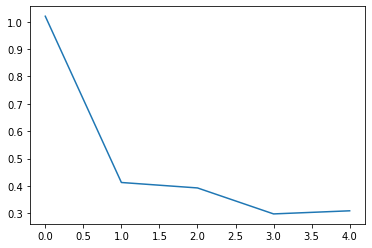

In [42]:
width = []
lbs = []
ubs = []
for N in [100,1000,2000,5000,10000]:
    states = [x for x in range(10)]
    estimates_test, intervals_test = bootstrap_marginal(states,[0,0],[0.8,0.2,0.5,1],100,N,N,plot=False,printing=False)
    ub, lb = gene_expression_LP_3([0.8,0.2,"v",1],10,intervals_test,printing=False)
    ubs.append(ub)
    lbs.append(lb)
    print(f"({lb},{ub})")
    width.append(ub - lb)
plt.plot(width)    

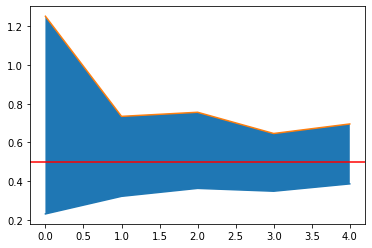

In [49]:
fig, ax = plt.subplots()
ax.plot(lbs)
ax.plot(ubs)
ax.fill_between([x for x in range(5)],lbs, ubs)
ax.axhline(0.5, color="red")

See that width does indeed decrease as the sample size increases: the outer approximation of the parameter becomes closer to the true value (as possible range given by data becomes smaller)

# Parameter Influence:

With the frechet bounds, and even [0,1] bounds, the ratio of k1 to k2 i.e. how "birth-death like" the process is, affects the quality of the bounds (bounds on solution in [0,1] case) (bounds on p's / z's in frechet case, and so also on solution). When k1 ~ k2 the frechet bounds do not give non-zero lower bounds, and so like [0,1] bounds give no upper bound on the solution, and poor lower bounds. When k1 >> k2, some (usually only 1) frechet lower bounds are non-zero and so give good solution bounds.

Plot the solution width/bounds for different k1,k2 values

(0.024665981499291813,inf)
(0.12773302646571594,inf)
(0.20595533497623478,inf)
(0.245161290312133,10.984615385223892)
(0.24415584415209257,1.254100529101815)
(0.29918032786738,0.8326530612255879)
(0.31559652246604897,0.7045565744414256)
(0.3319088319058679,0.6646734130648336)
(0.3771680041414802,0.4957376610507218)


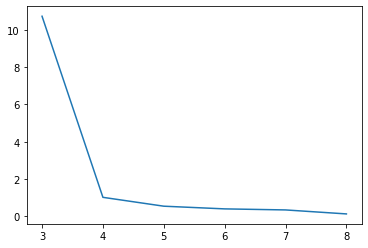

In [50]:
width = []
lbs = []
ubs = []
N = 1000
for k1 in [0.1,0.5,1,1.5,2,3,4,5,10]:
    states = [x for x in range(10)]
    estimates_test, intervals_test = bootstrap_marginal(states,[0,0],[k1,1,0.5,1],100,N,N,plot=False,printing=False)
    ub, lb = gene_expression_LP_3([k1,1,"v",1],10,intervals_test,printing=False)
    ubs.append(ub)
    lbs.append(lb)
    print(f"({lb},{ub})")
    width.append(ub - lb)
plt.plot(width)    

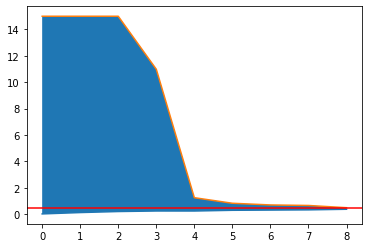

In [71]:
ubs_adj = [x if x < 15 else 15 for x in ubs]
fig, ax = plt.subplots()
ax.plot(lbs)
ax.plot(ubs_adj)
ax.fill_between([x for x in range(9)],lbs, ubs_adj)
ax.axhline(0.5, color="red")

(0.24641460234072,1.2905827787873498)
(0.3286713286645071,0.9446254071831008)
(0.3649270072899038,0.8471321048554316)
(0.3574529667135161,0.7032208589114051)
(0.3441049961378057,0.6451510895793505)
(0.3898437499974423,0.6307929969842875)
(0.3183619087677741,0.5390508276849675)
(0.39059613136644916,0.6283708251920853)
(0.36453147876812886,0.4815997487339583)
(0.3604826545991146,0.5761002716306527)
(0.46829268292564896,0.495619524417855)
(0.39484134488085615,0.4835399743743456)
(inf,-inf)


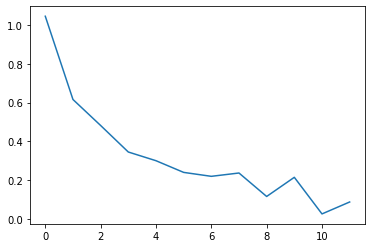

In [103]:
width = []
lbs = []
ubs = []
N = 1000
for k1 in [x for x in range(2,15)]:
    states = [x for x in range(10)]
    estimates_test, intervals_test = bootstrap_marginal(states,[0,0],[k1,1,0.5,1],100,N,N,plot=False,printing=False)
    ub, lb = gene_expression_LP_3([k1,1,"v",1],10,intervals_test,printing=False)
    ubs.append(ub)
    lbs.append(lb)
    print(f"({lb},{ub})")
    width.append(ub - lb)
plt.plot(width)

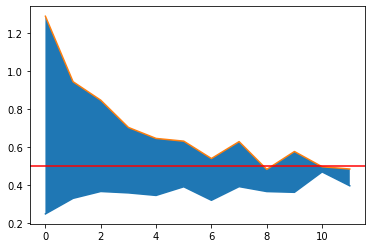

In [105]:
ubs_adj = [x if x < 2 else 2 for x in ubs]
lbs_adj = [x if x > 0 else 0 for x in lbs]
fig, ax = plt.subplots()
ax.plot(lbs_adj)
ax.plot(ubs_adj)
ax.fill_between([x for x in range(13)],lbs_adj, ubs_adj)
ax.axhline(0.5, color="red")

# Gene Expression

Following the exploratory work done above we produce updated code, implementing faster sampling, optimizated bootstrap and combining the different LP constraint forms into one function with options as arguments.

In [2]:
import math, random
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cv
import time
import scipy

## Sample Path Simulation

Optimize sample path simulation: instead of running n chains up to t_max and taking a single sample each, we now run a single chain up to t_max and then take samples at t_s << t_max intervals. This massively increases efficiency as we do not have a run long burn-in for each sample, but t_s must be large enough to avoid high dependence of samples. (the old method can be considered t_max = t_s)

In [3]:
def sample_path_gene(initial_state, params, tmax, plot=False):
    """
    Simulate a sample path of gene expression
    start at initial state, run until time tmax, rates in params
    return visited states and jump times
    """

    # initialise time and state (also store jump times)
    t = 0
    path = [(initial_state[0],initial_state[1])]
    jump_times = [0]
    k_on, k_off, k_tx, k_deg = params[0], params[1], params[2], params[3]

    # simulate until stopping time
    while t < tmax:
        # simulate holding time of current state (m,g)
        m, g = path[-1][0], path[-1][1]

        # define rates
        # q(x,x+(0,1)): gene turns on if off
        q_on = (1 - g) * k_on
        # q(x,x+(0,-1)): gene turns off if on
        q_off = g * k_off
        # q(x,x+(1,0)): transcription if gene on
        q_tx = g * k_tx
        # q(x,x+(-1,0)): degradation if  there are molecules
        q_deg = m * k_deg
        # -q(x,x): holding rate = sum q(x,y) over y
        q_hold = q_on + q_off + q_tx + q_deg

        # exponential holding time of state
        t_hold = -math.log(random.random()) / q_hold
        t += t_hold
        jump_times.append(t)

        # jump probability
        # P(x -> y) = q_xy / q_hold
        outcome = [1,2,3,4]
        prob = [q_on / q_hold, q_off / q_hold, q_tx / q_hold, q_deg / q_hold]
        jump = np.random.choice(outcome,p=prob)
        # jump to new state
        if jump == 1:
            path.append((m,g + 1))
        elif jump == 2:
            path.append((m,g - 1))
        elif jump == 3:
            path.append((m + 1,g))
        elif jump == 4:
            path.append((m - 1,g))

    if plot:
        # separate paths
        m_path = [state[0] for state in path]
        g_path = [state[1] for state in path]
        plt.scatter(jump_times, m_path, c=g_path, ec='k')

        # defined colour plotting
        #cmap, norm = mcolors.from_levels_and_colors([0, 1, 2], ['orange','blue'])
        #plt.scatter(jump_times, m_list, c=g_list, cmap=cmap, norm=norm)

    return path, jump_times

In [4]:
def sample_path_approximate(initial_state, params, n, tmax, ts, plot=False):
    """
    Simulate a single sample path of gene expression
    Sample values at intervals ts after a burn-in time of tmax to give n values

    initial state
    params = [k_on, k_off, k_tx, k_deg]
    n = total number of samples
    tmax = burn-in simulation time
    ts = time between successive samples

    return samples of m
    """

    # parameters
    k_on = params[0]
    k_off = params[1]
    k_tx = params[2]
    k_deg = params[3]

    # initialise time and state (also store jump times)
    t = 0
    path = [(initial_state[0], initial_state[1])]
    jump_times = [0]

    # simulate for: burn-in time + (n-1) times between n samples
    while t < tmax + (n - 1) * ts:

        # simulate holding time of current state (m,g)
        m, g = path[-1][0], path[-1][1]

        # define rates
        # q(x,x+(0,1)): gene turns on if off
        q_on = (1 - g) * k_on
        # q(x,x+(0,-1)): gene turns off if on
        q_off = g * k_off
        # q(x,x+(1,0)): transcription if gene on
        q_tx = g * k_tx
        # q(x,x+(-1,0)): degradation if  there are molecules
        q_deg = m * k_deg
        # -q(x,x): holding rate = sum q(x,y) over y
        q_hold = q_on + q_off + q_tx + q_deg

        # exponential holding time of state
        t_hold = -math.log(random.random()) / q_hold
        t += t_hold
        jump_times.append(t)

        # jump probability
        # P(x -> y) = q_xy / q_hold
        outcome = [1,2,3,4]
        prob = [q_on / q_hold, q_off / q_hold, q_tx / q_hold, q_deg / q_hold]
        jump = np.random.choice(outcome,p=prob)
        # jump to new state
        if jump == 1:
            path.append((m,g + 1))
        elif jump == 2:
            path.append((m,g - 1))
        elif jump == 3:
            path.append((m + 1,g))
        elif jump == 4:
            path.append((m - 1,g))

    # take the m marginal states
    m_path = [state[0] for state in path]

    # create step function of sample path from jump times and jump values
    path_function = scipy.interpolate.interp1d(jump_times, m_path, kind='previous')
    
    # take values at sampling times as samples
    sample_times = [tmax + i * ts for i in range(n)]
    samples = path_function(sample_times)
    samples = [int(x) for x in samples]

    # plot sample path with burn-in and sampled values
    if plot:
        x = np.linspace(0, tmax + (n - 1) * ts, 10000)
        plt.plot(x, path_function(x), label="Sample path")
        plt.axvline(tmax, label="Burn-in time: t_max", color="orange")
        plt.scatter(sample_times, path_function(sample_times), color="red", label="Samples")
        plt.legend()
        plt.show()

    return samples

### Bootstrap

Using the new vectorized method allows for a significant optimization in confidence interval computation time. However, we are still slowed down by inefficient simulation of n individual sample paths (one full burn-in path for each sampled value).

So can use new optimized approx sampling to speed up.


In [5]:
def bootstrap_marginal(m_list, initial_state, params, tmax, n, N, plot=False, printing=False):
    """
    m_list: marginal states of m to calculate probabilities for
    initial state
    parameters
    tmax: time of path before sample
    n = number of simulated samples
    N = number of bootstrap samples
    """

    s1 = time.time()
    # simulate n samples: (m,g)
    states = []
    for i in range(n):
        path, jumps = sample_path_gene(initial_state, params, tmax, plot=plot)
        states.append(path[-2]) # last state before tmax
    plt.show()
    e1 = time.time()
    print(f"Simulation time: {e1 - s1}")

    s2 = time.time()
    # simulate N bootstrap samples: estimates p(m) for each, and for each m
    estimates = [[] for x in m_list]
    for i in range(N):
        # sample with replacement from (m,g) samples
        sample = random.choices(states,k = n)
        # take just marginal m information
        m_sample = [state[0] for state in sample]
        # estimate p(m) from marginal info
        for i, x in enumerate(m_list):
            estimates[i].append(m_sample.count(x) / n)

    # create confidence intervals (95%) via 2.5%, 97.5% quantiles for each x
    intervals = [np.quantile(est,[0.025,0.975]) for est in estimates]
    e2 = time.time()
    print(f"Computation time: {e2 - s2}")

    # plot histograms and CI
    for i, x in enumerate(m_list):
        if printing:
            print(f"95% CI for p({x}) is: ({intervals[i][0]}, {intervals[i][1]})")
        if plot:
            plt.hist(estimates[i])
            plt.title(f"Hist of p({x})")
            plt.axvline(intervals[i][0], color="red")
            plt.axvline(intervals[i][1], color="red")
            plt.show()

    # return CIs
    return estimates, intervals

In [6]:
def bootstrap_marginal_optim(initial_state, params, n, N, tmax=100, plot=False, printing=False):
    """
    Simulate sample paths of reaction system, bootstrap to produce confidence
    intervals on the m marginals of the stationary distributin.

    Arguments:
    initial_state: start of each simulated sample path (m, g)
    params: parameters of chain for simulation [k_on, k_off, k_tx, k_deg]
    n: number of simulated sample paths
    N: number of bootstrap samples
    tmax: time of each sample path
    plot: plot the computed bounds
    print: print the computed bounds

    Returns:
    intervals: list of confidence intervals for m marginals p(0), ..., p(M - 1)
        of the stationary distribution of the chain
    """

    s1 = time.time()
    # simulate n stationary samples: (m,g) (joint state not just marginal)
    states = []
    for i in range(n):
        path, jumps = sample_path_gene(initial_state, params, tmax)
        # last state before tmax
        states.append(path[-2])
    e1 = time.time()
    print(f"Simulation time: {e1 - s1}")

    s2 = time.time()
    # take the m marginal states
    m_sample = [state[0] for state in states]

    # find the largest state (+ 1)
    M = np.max(m_sample) + 1

    # N boostrap samples as N x n array
    bootstrap = np.random.choice(m_sample, size=(N, n))
    # produce N x M array of counts of states:
    # offset each row by multiple of M for efficient bincount
    bootstrap_offs = bootstrap + np.arange(N)[:,None]*M
    counts = np.bincount(bootstrap_offs.ravel(), minlength=N * M).reshape(-1, M)
    # dividing by n gives columns of estimates
    # take 2.5%, 97.5% percentiles of each column (i.e each p(x))
    quantiles = np.quantile(counts / n, [0.025, 0.975], axis=0)
    # form intervals: list of [2.5%, 97.5%] values for each p(x)
    intervals = [quantiles[:,i] for i in range(M)]
    e2 = time.time()
    print(f"Computation time: {e2 - s2}")

    # plot histograms and CI
    for x in range(M):
        if printing:
            print(f"95% CI for m marginal p({x}) is: ({intervals[x][0]}, {intervals[x][1]})")
        if plot:
            plt.hist(counts[:, x] / n)
            plt.title(f"Hist of m marginal p({x})")
            plt.axvline(intervals[x][0], color="red")
            plt.axvline(intervals[x][1], color="red")
            plt.show()

    # return CIs
    return intervals

In [7]:
def bootstrap_approx(initial_state, params, n, N, tmax=100, ts=10, plot=False, printing=False):
    """
    Simulate sample paths of reaction system, bootstrap to produce confidence
    intervals on the m marginals of the stationary distributin.

    Arguments:
    initial_state: start of each simulated sample path (m, g)
    params: parameters of chain for simulation [k_on, k_off, k_tx, k_deg]
    n: number of simulated sample paths
    N: number of bootstrap samples
    tmax: burn-in time of sample path
    ts: time between each sample
    plot: plot the computed bounds
    print: print the computed bounds

    Returns:
    intervals: list of confidence intervals for m marginals p(0), ..., p(M - 1)
        of the stationary distribution of the chain
    """

    # simulate n stationary samples (of m marginal)
    m_sample = sample_path_approximate(initial_state, params, n, tmax, ts, plot=plot)

    # find the largest state (+ 1)
    M = np.max(m_sample) + 1

    # N boostrap samples as N x n array
    bootstrap = np.random.choice(m_sample, size=(N, n))
    # produce N x M array of counts of states:
    # offset each row by multiple of M for efficient bincount
    bootstrap_offs = bootstrap + np.arange(N)[:,None]*M
    counts = np.bincount(bootstrap_offs.ravel(), minlength=N * M).reshape(-1, M)
    # dividing by n gives columns of estimates
    # take 2.5%, 97.5% percentiles of each column (i.e each p(x))
    quantiles = np.quantile(counts / n, [0.025, 0.975], axis=0)
    # form intervals: list of [2.5%, 97.5%] values for each p(x)
    intervals = [quantiles[:,i] for i in range(M)]

    # plot histograms and CI
    for x in range(M):
        if printing:
            print(f"95% CI for m marginal p({x}) is: ({intervals[x][0]}, {intervals[x][1]})")
        if plot:
            plt.hist(counts[:, x] / n)
            plt.title(f"Hist of m marginal p({x})")
            plt.axvline(intervals[x][0], color="red")
            plt.axvline(intervals[x][1], color="red")
            plt.show()

    # return CIs
    return intervals

In [28]:
estimates, intervals = bootstrap_marginal([m for m in range(8)], (0, 0), [2, 1, 2, 1], 100, 5000, 5000, plot=False, printing=True)

Simulation time: 38.18250107765198
Computation time: 6.950066566467285
95% CI for p(0) is: (0.2772, 0.3026049999999999)
95% CI for p(1) is: (0.316, 0.3418)
95% CI for p(2) is: (0.2082, 0.2312)
95% CI for p(3) is: (0.0918, 0.1084)
95% CI for p(4) is: (0.0364, 0.0474)
95% CI for p(5) is: (0.011, 0.0172)
95% CI for p(6) is: (0.0028, 0.0066)
95% CI for p(7) is: (0.0002, 0.002)


In [29]:
intervals_optim = bootstrap_marginal_optim((0, 0), [2, 1, 2, 1], 5000, 5000, tmax=100, plot=False, printing=True)

Simulation time: 50.840245485305786
Computation time: 1.0689888000488281
95% CI for m marginal p(0) is: (0.2844, 0.3108)
95% CI for m marginal p(1) is: (0.3096, 0.336)
95% CI for m marginal p(2) is: (0.2052, 0.2278)
95% CI for m marginal p(3) is: (0.0952, 0.1118)
95% CI for m marginal p(4) is: (0.0356, 0.0468)
95% CI for m marginal p(5) is: (0.011, 0.0176)
95% CI for m marginal p(6) is: (0.0026, 0.0062)
95% CI for m marginal p(7) is: (0.0, 0.001)
95% CI for m marginal p(8) is: (0.0, 0.0)
95% CI for m marginal p(9) is: (0.0, 0.0006)


In [30]:
s = time.time()
intervals_approx = bootstrap_approx((0, 0), [2, 1, 2, 1], 5000, 5000, tmax=100, ts=10, plot=False, printing=True)
print(f"Time: {time.time() - s}")

95% CI for m marginal p(0) is: (0.280795, 0.306)
95% CI for m marginal p(1) is: (0.307, 0.3334)
95% CI for m marginal p(2) is: (0.2018, 0.2246)
95% CI for m marginal p(3) is: (0.1024, 0.1194)
95% CI for m marginal p(4) is: (0.037, 0.0482)
95% CI for m marginal p(5) is: (0.010595000000000002, 0.0168)
95% CI for m marginal p(6) is: (0.0036, 0.0074)
95% CI for m marginal p(7) is: (0.0002, 0.002)
Time: 6.593452453613281


See "approx" sampling is much faster, and optimized bootstrap adds a speedup. There is a risk of dependent samples leading to poor CI's, but the better efficiency means that we can easily use a larger sample size as long as ts is reasonable.

## Fix wrong Q_deg matrix

q((m,g),(m-1,g)) = k_deg * m, but the factor of m was not there.

In [31]:
# wrong implementation
N = 5
Q_deg_wrong = (np.diag([-1 if x > 1 else 0 for x in range(0,N+2)],0) +
    		np.diag([1 for x in range(0,N)],2))[:-2, :]
print(f"Wrong Q_deg: \n{Q_deg_wrong}")

diag = []
off_diag = []
m = 0
for x in range(0, N + 2):
    diag.append(-m)
    if x > 1:
        off_diag.append(m)
    # every 2 entries, increase m by 1
    if x % 2:
        m += 1

# correct implementation
Q_deg = (np.diag(diag,0) + np.diag(off_diag,2))[:-2, :]
print(f"Corrected Q_deg: \n{Q_deg}")

Wrong Q_deg: 
[[ 0  0  1  0  0  0  0]
 [ 0  0  0  1  0  0  0]
 [ 0  0 -1  0  1  0  0]
 [ 0  0  0 -1  0  1  0]
 [ 0  0  0  0 -1  0  1]]
Corrected Q_deg: 
[[ 0  0  1  0  0  0  0]
 [ 0  0  0  1  0  0  0]
 [ 0  0 -1  0  2  0  0]
 [ 0  0  0 -1  0  2  0]
 [ 0  0  0  0 -2  0  3]]


## LP

Now add arguments for constraint settings:
- frechet_bounds: toggle standard frechet bound constraints
- frechet_bounds_further: toggle further bounds (only linear when $ k_{on} $ and $ k_{off} $ are fixed)

NOTE: the missing distributional constraint on the joint p, sum of entries $ \le $ 1 (due to truncation), is also added. Although, does not appear to have significant impact.

In [38]:
def gene_expression_LP_optim(params, N, intervals, frechet_bounds=True, frechet_bounds_further=False, print_solution=True):
    """
    Solve gene expression LP to bound parameters

    Inputs:
    params: [k_on, k_off, k_tx, k_deg] either values that will be fixed, or "v"
        for variable to be bounded
    N: number of rows/equations of Qp = 0 to use in constraints
        must be even
    intervals: list of confidence intervals for at least N/2 + 1 marginal states
    """
	
	# number of marginals used
    M = int(N/2 + 1)

	# create Qr matrices:
	# create N + 2 x N + 2 square and drop last 2 rows, as have 2 upper diagonals
    Q_on = (np.diag([-1 if not x % 2 else 0 for x in range(0,N+2)],0) +
    		np.diag([1 if not x % 2 else 0 for x in range(0,N+1)],-1))[:-2, :]
    Q_off = (np.diag([-1 if x % 2 else 0 for x in range(0,N+2)],0) +
    		np.diag([1 if not x % 2 else 0 for x in range(0,N+1)],1))[:-2, :]
    Q_tx = (np.diag([-1 if x % 2 else 0 for x in range(0,N+2)],0) +
    		np.diag([1 if x % 2 else 0 for x in range(0,N)],-2))[:-2, :]
    diag = []
    off_diag = []
    m = 0
    for x in range(0, N + 2):
        diag.append(-m)
        if x > 1:
            off_diag.append(m)
        # every 2 entries, increase m by 1
        if x % 2:
            m += 1
    Q_deg = (np.diag(diag,0) + np.diag(off_diag,2))[:-2, :]

    # bounds from CI, on marginal
    pl = [intr[0] for intr in intervals]
    pu = [intr[1] for intr in intervals]

    # define bounds
    pl = np.array(pl)[:M]
    pu = np.array(pu)[:M]

    # form doubled bounds
    pdl = np.repeat(pl,2)
    pdu = np.repeat(pu,2)

    # NOTE: need different cutoff: n p's <=> n/2 marginals
	
    # marginal = A @ p
    A = np.repeat(np.eye(M, dtype=int), repeats=2, axis=1)

	# Construct the problem.
    # Variables
    k1, k2, k3, k4 = params[0], params[1], params[2], params[3]
    if k1 == "v":
        k_on = cv.Variable()
    else:
        k_on = k1
    if k2 == "v":
        k_off = cv.Variable()
    else:
        k_off = k2
    if k3 == "v":
        k_tx = cv.Variable()
    else:
        k_tx = k3
    if k4 == "v":
        k_deg = cv.Variable()
    else:
        k_deg = k4
    z_on = cv.Variable(N + 2)
    z_off = cv.Variable(N + 2)
    z_tx = cv.Variable(N + 2)
    z_deg = cv.Variable(N + 2)

    # frechet bound vector
    kv1 = np.array([0 if x % 2 else 1 for x in range(N + 2)])
    kv2 = np.array([1 if x % 2 else 0 for x in range(N + 2)])
    kv = k_on * kv1 + k_off * kv2
    #kv = np.array([k_off if x % 2 else k_on for x in range(N + 2)])

	# Constraints
    constraints = [
        # Qp = 0
        Q_on @ z_on + Q_off @ z_off + Q_tx @ z_tx + Q_deg @ z_deg == 0,
        # k_r * p_L <= A @ z_r <= k_r * p_U
        k_on * pl <= A @ z_on, A @ z_on <= k_on * pu,
		k_off * pl <= A @ z_off, A @ z_off <= k_off * pu,
		k_tx * pl <= A @ z_tx, A @ z_tx <= k_tx * pu,
		k_deg * pl <= A @ z_deg, A @ z_deg <= k_deg * pu,
        # 0 <= z_r <= k_r , k_r >= 0
        0 <= z_on, z_on <= k_on, k_on >= 0,
        0 <= z_off, z_off <= k_off, k_off >= 0,
        0 <= z_tx, z_tx <= k_tx, k_tx >= 0,
        0 <= z_deg, z_deg <= k_deg, k_deg >= 0,
        # sum( z_r entries ) <= k_r
        sum([z_on[x] for x in range(N + 2)]) <= k_on,
        sum([z_off[x] for x in range(N + 2)]) <= k_off,
        sum([z_tx[x] for x in range(N + 2)]) <= k_tx,
        sum([z_deg[x] for x in range(N + 2)]) <= k_deg,
        # joint upper bounds: z_r <= k_r * p_DU
    	z_on <= k_on * pdu, z_off <= k_off * pdu, z_tx <= k_tx * pdu, z_deg <= k_deg * pdu
    ]
    if frechet_bounds:
        constraints += [
            # frechet lower bounds (individuals may be redundant)
            z_on >= k_on * pdl + k_off * pdl - kv - k_off * pdu,
            z_off >= k_on * pdl + k_off * pdl - kv - k_on * pdu,
            z_on + z_off >= k_on * pdl + k_off * pdl - kv
        ]

    if frechet_bounds_further:
        constraints += [
            # further frechet bounds (need k_on and k_off fixed)
            z_tx >= (k_on * pdl + k_off * pdl - kv - k_off * pdu) * (k_tx / k_on),
            z_deg >= (k_on * pdl + k_off * pdl - kv - k_off * pdu) * (k_deg / k_on),
            z_tx >= (k_on * pdl + k_off * pdl - kv - k_on * pdu) * (k_tx / k_off),
            z_deg >= (k_on * pdl + k_off * pdl - kv - k_on * pdu) * (k_deg / k_off)
        ]
    
    # solutions
    solutions = {}

    # optimize for each variable
    if k1 == "v":
        prob_min = cv.Problem(cv.Minimize(k_on), constraints)
        prob_max = cv.Problem(cv.Maximize(k_on), constraints)
        prob_min.solve(solver=cv.GUROBI)
        prob_max.solve(solver=cv.GUROBI)
        solutions["k_on"] = [prob_min.value, prob_max.value, prob_min.status, prob_max.status]
    else:
        solutions["k_on"] = [k1]
    if k2 == "v":
        prob_min = cv.Problem(cv.Minimize(k_off), constraints)
        prob_max = cv.Problem(cv.Maximize(k_off), constraints)
        prob_min.solve(solver=cv.GUROBI)
        prob_max.solve(solver=cv.GUROBI)
        solutions["k_off"] = [prob_min.value, prob_max.value, prob_min.status, prob_max.status]
    else:
        solutions["k_off"] = [k2]
    if k3 == "v":
        prob_min = cv.Problem(cv.Minimize(k_tx), constraints)
        prob_max = cv.Problem(cv.Maximize(k_tx), constraints)
        prob_min.solve(solver=cv.GUROBI)
        prob_max.solve(solver=cv.GUROBI)
        solutions["k_tx"] = [prob_min.value, prob_max.value, prob_min.status, prob_max.status]
    else:
        solutions["k_tx"] = [k3]
    if k4 == "v":
        prob_min = cv.Problem(cv.Minimize(k_deg), constraints)
        prob_max = cv.Problem(cv.Maximize(k_deg), constraints)
        prob_min.solve(solver=cv.GUROBI)
        prob_max.solve(solver=cv.GUROBI)
        solutions["k_deg"] = [prob_min.value, prob_max.value, prob_min.status, prob_max.status]
    else:
        solutions["k_deg"] = [k4]

    if print_solution:
        for var in ["k_on", "k_off", "k_tx", "k_deg"]:
            try:
                print(f"\n{var} in ({solutions[var][0]}, {solutions[var][1]}) , status: {solutions[var][2]} , {solutions[var][3]}")
            except:
                print(f"\n{var} = {solutions[var][0]}")

    return solutions

In [39]:
def gene_expression_LP_update(params, N, intervals, frechet_bounds=True, frechet_bounds_further=False, print_solution=True):
    """
    Solve gene expression LP to bound parameters

    Inputs:
    params: [k_on, k_off, k_tx, k_deg] either values that will be fixed, or "v"
        for variable to be bounded
    N: number of rows/equations of Qp = 0 to use in constraints
        must be even
    intervals: list of confidence intervals for at least N/2 + 1 marginal states
    """
	
	# number of marginals used
    M = int(N/2 + 1)

	# create Qr matrices:
	# create N + 2 x N + 2 square and drop last 2 rows, as have 2 upper diagonals
    Q_on = (np.diag([-1 if not x % 2 else 0 for x in range(0,N+2)],0) +
    		np.diag([1 if not x % 2 else 0 for x in range(0,N+1)],-1))[:-2, :]
    Q_off = (np.diag([-1 if x % 2 else 0 for x in range(0,N+2)],0) +
    		np.diag([1 if not x % 2 else 0 for x in range(0,N+1)],1))[:-2, :]
    Q_tx = (np.diag([-1 if x % 2 else 0 for x in range(0,N+2)],0) +
    		np.diag([1 if x % 2 else 0 for x in range(0,N)],-2))[:-2, :]
    diag = []
    off_diag = []
    m = 0
    for x in range(0, N + 2):
        diag.append(-m)
        if x > 1:
            off_diag.append(m)
        # every 2 entries, increase m by 1
        if x % 2:
            m += 1
    Q_deg = (np.diag(diag,0) + np.diag(off_diag,2))[:-2, :]

    # bounds from CI, on marginal
    pl = [intr[0] for intr in intervals]
    pu = [intr[1] for intr in intervals]

    # define bounds
    pl = np.array(pl)[:M]
    pu = np.array(pu)[:M]

    # form doubled bounds
    pdl = np.repeat(pl,2)
    pdu = np.repeat(pu,2)

    # NOTE: need different cutoff: n p's <=> n/2 marginals
	
    # marginal = A @ p
    A = np.repeat(np.eye(M, dtype=int), repeats=2, axis=1)

	# Construct the problem.
    # Variables
    k1, k2, k3, k4 = params[0], params[1], params[2], params[3]
    if k1 == "v":
        k_on = cv.Variable()
    else:
        k_on = k1
    if k2 == "v":
        k_off = cv.Variable()
    else:
        k_off = k2
    if k3 == "v":
        k_tx = cv.Variable()
    else:
        k_tx = k3
    if k4 == "v":
        k_deg = cv.Variable()
    else:
        k_deg = k4
    z_on = cv.Variable(N + 2)
    z_off = cv.Variable(N + 2)
    z_tx = cv.Variable(N + 2)
    z_deg = cv.Variable(N + 2)

    # frechet bound vector
    kv_off = np.array([0 if x % 2 else 1 for x in range(N + 2)])
    kv_on = np.array([1 if x % 2 else 0 for x in range(N + 2)])
    kv = k_off * kv_off + k_on * kv_on

	# Constraints
    constraints = [
        # Qp = 0
        Q_on @ z_on + Q_off @ z_off + Q_tx @ z_tx + Q_deg @ z_deg == 0,
        # k_r * p_L <= A @ z_r <= k_r * p_U
        k_on * pl <= A @ z_on, A @ z_on <= k_on * pu,
		k_off * pl <= A @ z_off, A @ z_off <= k_off * pu,
		k_tx * pl <= A @ z_tx, A @ z_tx <= k_tx * pu,
		k_deg * pl <= A @ z_deg, A @ z_deg <= k_deg * pu,
        # 0 <= z_r <= k_r , k_r >= 0
        0 <= z_on, z_on <= k_on, k_on >= 0,
        0 <= z_off, z_off <= k_off, k_off >= 0,
        0 <= z_tx, z_tx <= k_tx, k_tx >= 0,
        0 <= z_deg, z_deg <= k_deg, k_deg >= 0,
        # sum( z_r entries ) <= k_r
        sum([z_on[x] for x in range(N + 2)]) <= k_on,
        sum([z_off[x] for x in range(N + 2)]) <= k_off,
        sum([z_tx[x] for x in range(N + 2)]) <= k_tx,
        sum([z_deg[x] for x in range(N + 2)]) <= k_deg,
        # joint upper bounds: z_r <= k_r * p_DU
    	z_on <= k_on * pdu, z_off <= k_off * pdu, z_tx <= k_tx * pdu, z_deg <= k_deg * pdu
    ]
    if frechet_bounds:
        constraints += [
            z_on + z_off <= kv
        ]

    if frechet_bounds_further:
        constraints += [
            # for k_on and k_off fixed
            z_on == (k_on / k_off) * z_off,
            (k_on + k_off) * z_tx <= k_tx * kv,
            (k_on + k_off) * z_deg <= k_deg * kv
        ]
    
    # solutions
    solutions = {}

    # optimize for each variable
    if k1 == "v":
        prob_min = cv.Problem(cv.Minimize(k_on), constraints)
        prob_max = cv.Problem(cv.Maximize(k_on), constraints)
        prob_min.solve(solver=cv.GUROBI)
        prob_max.solve(solver=cv.GUROBI)
        solutions["k_on"] = [prob_min.value, prob_max.value, prob_min.status, prob_max.status]
    else:
        solutions["k_on"] = [k1]
    if k2 == "v":
        prob_min = cv.Problem(cv.Minimize(k_off), constraints)
        prob_max = cv.Problem(cv.Maximize(k_off), constraints)
        prob_min.solve(solver=cv.GUROBI)
        prob_max.solve(solver=cv.GUROBI)
        solutions["k_off"] = [prob_min.value, prob_max.value, prob_min.status, prob_max.status]
    else:
        solutions["k_off"] = [k2]
    if k3 == "v":
        prob_min = cv.Problem(cv.Minimize(k_tx), constraints)
        prob_max = cv.Problem(cv.Maximize(k_tx), constraints)
        prob_min.solve(solver=cv.GUROBI)
        prob_max.solve(solver=cv.GUROBI)
        solutions["k_tx"] = [prob_min.value, prob_max.value, prob_min.status, prob_max.status]
    else:
        solutions["k_tx"] = [k3]
    if k4 == "v":
        prob_min = cv.Problem(cv.Minimize(k_deg), constraints)
        prob_max = cv.Problem(cv.Maximize(k_deg), constraints)
        prob_min.solve(solver=cv.GUROBI)
        prob_max.solve(solver=cv.GUROBI)
        solutions["k_deg"] = [prob_min.value, prob_max.value, prob_min.status, prob_max.status]
    else:
        solutions["k_deg"] = [k4]

    if print_solution:
        for var in ["k_on", "k_off", "k_tx", "k_deg"]:
            try:
                print(f"\n{var} in ({solutions[var][0]}, {solutions[var][1]}) , status: {solutions[var][2]} , {solutions[var][3]}")
            except:
                print(f"\n{var} = {solutions[var][0]}")

    return solutions

## Tests

In [40]:
intervals_optim = bootstrap_marginal_optim(initial_state=(0, 0), params=[1, 1, 1, 1], n=1000, N=1000, tmax=100, plot=False, printing=True)

Simulation time: 3.3336849212646484
Computation time: 0.020424604415893555
95% CI for m marginal p(0) is: (0.605, 0.663)
95% CI for m marginal p(1) is: (0.241, 0.295025)
95% CI for m marginal p(2) is: (0.053, 0.087)
95% CI for m marginal p(3) is: (0.012, 0.029)
95% CI for m marginal p(4) is: (0.002, 0.011)
95% CI for m marginal p(5) is: (0.0, 0.0)
95% CI for m marginal p(6) is: (0.0, 0.003)


In [41]:
solutions = gene_expression_LP_optim(params=[1, 1, "v", 1], N=8, frechet_bounds=True, frechet_bounds_further=True, intervals=intervals_optim)
print(10*"-")
solutions_new = gene_expression_LP_update(params=[1, 1, "v", 1], N=8, frechet_bounds=True, frechet_bounds_further=True, intervals=intervals_optim)


k_on = 1

k_off = 1

k_tx in (0.4137931034482759, None) , status: optimal , infeasible_or_unbounded

k_deg = 1
----------

k_on = 1

k_off = 1

k_tx in (0.482, 2.809761904761905) , status: optimal , optimal

k_deg = 1


In [42]:
intervals_optim = bootstrap_marginal_optim(initial_state=(0, 0), params=[10, 1, 0.5, 1], n=5000, N=5000, tmax=100, plot=False, printing=True)

Simulation time: 21.08983063697815
Computation time: 0.7329769134521484
95% CI for m marginal p(0) is: (0.6302, 0.6568)
95% CI for m marginal p(1) is: (0.2644, 0.2888049999999999)
95% CI for m marginal p(2) is: (0.0598, 0.0738)
95% CI for m marginal p(3) is: (0.0088, 0.0146)
95% CI for m marginal p(4) is: (0.0004, 0.0022)
95% CI for m marginal p(5) is: (0.0, 0.0006)


In [43]:
solutions = gene_expression_LP_optim(params=[10, 1, "v", 1], N=8, frechet_bounds=True, frechet_bounds_further=True, intervals=intervals_optim)
print(10*"-")
solutions = gene_expression_LP_update(params=[10, 1, "v", 1], N=8, frechet_bounds=True, frechet_bounds_further=True, intervals=intervals_optim)


k_on = 10

k_off = 1

k_tx in (0.41421073879693177, 0.5474561170716911) , status: optimal , optimal

k_deg = 1
----------

k_on = 10

k_off = 1

k_tx in (0.4142107387969317, 0.5355272917298809) , status: optimal , optimal

k_deg = 1


In [44]:
solutions = gene_expression_LP_optim(params=["v", "v", "v", 1], N=8, frechet_bounds=True, frechet_bounds_further=False, intervals=intervals_optim)
print(10*"-")
solutions = gene_expression_LP_update(params=["v", "v", "v", 1], N=8, frechet_bounds=True, frechet_bounds_further=False, intervals=intervals_optim)


k_on in (0.0, None) , status: optimal , infeasible_or_unbounded

k_off in (0.0, None) , status: optimal , infeasible_or_unbounded

k_tx in (0.41421073879693177, None) , status: optimal , infeasible_or_unbounded

k_deg = 1
----------

k_on in (0.0, None) , status: optimal , infeasible_or_unbounded

k_off in (0.0, None) , status: optimal , infeasible_or_unbounded

k_tx in (0.41421073879693177, None) , status: optimal , infeasible_or_unbounded

k_deg = 1


## Results

The bounds produced on $ k_{tx} $ depend on several factors: quality/number of CI bounds, parameter values, frechet/further constraints used, which variables are specified, ...

### Standard

With only $ k_{deg} $ fixed to e.g. 1, only a lower bound is produced on $ k_{tx} $ which does not change with more bounds, but better quality CI's (higher n and N) do give an improvement. There is no upper bound, and frechet bounds do not give any change.

### Fixed variables

With $ k_{on} $ and $ k_{off} $ fixed (as well as $ k_{deg} $), only a lower bound is produced again, and it does not seem to improve on the standard case, even with frechet bounds. Slight improvement with better CI's.

(see 1st test above)

### Further frechet bounds

With all variables fixed, further frechet bounds (multiplying frechet bounds by e.g. $ k_{tx} / k_{on} $) are now linear and can be used. Lower bounds are roughly the same as before.

However, when $ k_{on} $ >> $ k_{off} $ e.g. 10 and 1, these new bounds give an upper bound on $ k_{tx} $, and in general the bounds are quite good (comparable to the lower bound in distance the true value). It improves slightly with better bounds (larger n and N), but not using more CI bounds (more equations).

(see 2nd test above)

# Rank of Linear approximation

In [51]:
def gene_expression_LP_optim_rank(params, N, intervals, frechet_bounds=True, frechet_bounds_further=False, print_solution=True):
    """
    Solve gene expression LP to bound parameters, return Z at each optimum for
    rank testing of approximation

    Inputs:
    params: [k_on, k_off, k_tx, k_deg] either values that will be fixed, or "v"
        for variable to be bounded
    N: number of rows/equations of Qp = 0 to use in constraints
        must be even
    intervals: list of confidence intervals for at least N/2 + 1 marginal states
    """
	
	# number of marginals used
    M = int(N/2 + 1)

	# create Qr matrices:
	# create N + 2 x N + 2 square and drop last 2 rows, as have 2 upper diagonals
    Q_on = (np.diag([-1 if not x % 2 else 0 for x in range(0,N+2)],0) +
    		np.diag([1 if not x % 2 else 0 for x in range(0,N+1)],-1))[:-2, :]
    Q_off = (np.diag([-1 if x % 2 else 0 for x in range(0,N+2)],0) +
    		np.diag([1 if not x % 2 else 0 for x in range(0,N+1)],1))[:-2, :]
    Q_tx = (np.diag([-1 if x % 2 else 0 for x in range(0,N+2)],0) +
    		np.diag([1 if x % 2 else 0 for x in range(0,N)],-2))[:-2, :]
    diag = []
    off_diag = []
    m = 0
    for x in range(0, N + 2):
        diag.append(-m)
        if x > 1:
            off_diag.append(m)
        # every 2 entries, increase m by 1
        if x % 2:
            m += 1

    # correct implementation
    Q_deg = (np.diag(diag,0) + np.diag(off_diag,2))[:-2, :]

    # bounds from CI, on marginal
    pl = [intr[0] for intr in intervals]
    pu = [intr[1] for intr in intervals]

    # define bounds
    pl = np.array(pl)[:M]
    pu = np.array(pu)[:M]

    # form doubled bounds
    pdl = np.repeat(pl,2)
    pdu = np.repeat(pu,2)

    # NOTE: need different cutoff: n p's <=> n/2 marginals
	
    # marginal = A @ p
    A = np.repeat(np.eye(M, dtype=int), repeats=2, axis=1)

	# Construct the problem.
    # Variables
    k1, k2, k3, k4 = params[0], params[1], params[2], params[3]
    if k1 == "v":
        k_on = cv.Variable()
    else:
        k_on = k1
    if k2 == "v":
        k_off = cv.Variable()
    else:
        k_off = k2
    if k3 == "v":
        k_tx = cv.Variable()
    else:
        k_tx = k3
    if k4 == "v":
        k_deg = cv.Variable()
    else:
        k_deg = k4
    z_on = cv.Variable(N + 2)
    z_off = cv.Variable(N + 2)
    z_tx = cv.Variable(N + 2)
    z_deg = cv.Variable(N + 2)

    # frechet bound vector
    kv_off = np.array([0 if x % 2 else 1 for x in range(N + 2)])
    kv_on = np.array([1 if x % 2 else 0 for x in range(N + 2)])
    kv = k_off * kv_off + k_on * kv_on

	# Constraints
    constraints = [
        # Qp = 0
        Q_on @ z_on + Q_off @ z_off + Q_tx @ z_tx + Q_deg @ z_deg == 0,
        # k_r * p_L <= A @ z_r <= k_r * p_U
        k_on * pl <= A @ z_on, A @ z_on <= k_on * pu,
		k_off * pl <= A @ z_off, A @ z_off <= k_off * pu,
		k_tx * pl <= A @ z_tx, A @ z_tx <= k_tx * pu,
		k_deg * pl <= A @ z_deg, A @ z_deg <= k_deg * pu,
        # 0 <= z_r <= k_r , k_r >= 0
        0 <= z_on, z_on <= k_on, k_on >= 0,
        0 <= z_off, z_off <= k_off, k_off >= 0,
        0 <= z_tx, z_tx <= k_tx, k_tx >= 0,
        0 <= z_deg, z_deg <= k_deg, k_deg >= 0,
        # sum( z_r entries ) <= k_r
        sum([z_on[x] for x in range(N + 2)]) <= k_on,
        sum([z_off[x] for x in range(N + 2)]) <= k_off,
        sum([z_tx[x] for x in range(N + 2)]) <= k_tx,
        sum([z_deg[x] for x in range(N + 2)]) <= k_deg,
        # joint upper bounds: z_r <= k_r * p_DU
    	z_on <= k_on * pdu, z_off <= k_off * pdu, z_tx <= k_tx * pdu, z_deg <= k_deg * pdu
    ]
    if frechet_bounds:
        constraints += [
            z_on + z_off <= kv
        ]

    if frechet_bounds_further:
        constraints += [
            # further frechet bounds (need k_on and k_off fixed)
            z_on == (k_on / k_off) * z_off,
            (k_on + k_off) * z_tx <= k_tx * kv,
            (k_on + k_off) * z_deg <= k_deg * kv
        ]
    
    # solutions
    solutions = {}
    # z values
    z_values = {"k_on": {}, "k_off": {}, "k_tx": {}, "k_deg": {}}

    # optimize for each variable
    if k1 == "v":
        prob_min = cv.Problem(cv.Minimize(k_on), constraints)
        prob_max = cv.Problem(cv.Maximize(k_on), constraints)
        # solve min: store z values at optima
        prob_min.solve(solver=cv.GUROBI)
        z_values["k_on"]["z_on_lb"] = z_on.value
        z_values["k_on"]["z_off_lb"] = z_off.value
        z_values["k_on"]["z_tx_lb"] = z_tx.value
        z_values["k_on"]["z_deg_lb"] = z_deg.value
        # solve max: store z values at optima
        prob_max.solve(solver=cv.GUROBI)
        z_values["k_on"]["z_on_ub"] = z_on.value
        z_values["k_on"]["z_off_ub"] = z_off.value
        z_values["k_on"]["z_tx_ub"] = z_tx.value
        z_values["k_on"]["z_deg_ub"] = z_deg.value
        solutions["k_on"] = [prob_min.value, prob_max.value, prob_min.status, prob_max.status]
    else:
        solutions["k_on"] = [k1]
    if k2 == "v":
        prob_min = cv.Problem(cv.Minimize(k_off), constraints)
        prob_max = cv.Problem(cv.Maximize(k_off), constraints)
        prob_min.solve(solver=cv.GUROBI)
        z_values["k_off"]["z_on_lb"] = z_on.value
        z_values["k_off"]["z_off_lb"] = z_off.value
        z_values["k_off"]["z_tx_lb"] = z_tx.value
        z_values["k_off"]["z_deg_lb"] = z_deg.value
        prob_max.solve(solver=cv.GUROBI)
        z_values["k_off"]["z_on_ub"] = z_on.value
        z_values["k_off"]["z_off_ub"] = z_off.value
        z_values["k_off"]["z_tx_ub"] = z_tx.value
        z_values["k_off"]["z_deg_ub"] = z_deg.value
        solutions["k_off"] = [prob_min.value, prob_max.value, prob_min.status, prob_max.status]
    else:
        solutions["k_off"] = [k2]
    if k3 == "v":
        prob_min = cv.Problem(cv.Minimize(k_tx), constraints)
        prob_max = cv.Problem(cv.Maximize(k_tx), constraints)
        prob_min.solve(solver=cv.GUROBI)
        z_values["k_tx"]["z_on_lb"] = z_on.value
        z_values["k_tx"]["z_off_lb"] = z_off.value
        z_values["k_tx"]["z_tx_lb"] = z_tx.value
        z_values["k_tx"]["z_deg_lb"] = z_deg.value
        prob_max.solve(solver=cv.GUROBI)
        z_values["k_tx"]["z_on_ub"] = z_on.value
        z_values["k_tx"]["z_off_ub"] = z_off.value
        z_values["k_tx"]["z_tx_ub"] = z_tx.value
        z_values["k_tx"]["z_deg_ub"] = z_deg.value
        solutions["k_tx"] = [prob_min.value, prob_max.value, prob_min.status, prob_max.status]
    else:
        solutions["k_tx"] = [k3]
    if k4 == "v":
        prob_min = cv.Problem(cv.Minimize(k_deg), constraints)
        prob_max = cv.Problem(cv.Maximize(k_deg), constraints)
        prob_min.solve(solver=cv.GUROBI)
        z_values["k_deg"]["z_on_lb"] = z_on.value
        z_values["k_deg"]["z_off_lb"] = z_off.value
        z_values["k_deg"]["z_tx_lb"] = z_tx.value
        z_values["k_deg"]["z_deg_lb"] = z_deg.value
        prob_max.solve(solver=cv.GUROBI)
        z_values["k_deg"]["z_on_ub"] = z_on.value
        z_values["k_deg"]["z_off_ub"] = z_off.value
        z_values["k_deg"]["z_tx_ub"] = z_tx.value
        z_values["k_deg"]["z_deg_ub"] = z_deg.value
        solutions["k_deg"] = [prob_min.value, prob_max.value, prob_min.status, prob_max.status]
    else:
        solutions["k_deg"] = [k4]

    if print_solution:
        for var in ["k_on", "k_off", "k_tx", "k_deg"]:
            try:
                print(f"\n{var} in ({solutions[var][0]}, {solutions[var][1]}) , status: {solutions[var][2]} , {solutions[var][3]}")
            except:
                print(f"\n{var} = {solutions[var][0]}")

    return solutions, z_values

In [22]:
# parameters
k_tx = 2
k_deg = 1

# sample and bootstrap for k_on = 1, k_off = 0 (starting point of simulations M = 0, Gene on state)
intervals_rank = bootstrap_marginal_optim(initial_state=(0, 1), params=[1, 0, k_tx, k_deg], n=1000, N=1000, tmax=100, plot=False, printing=False)

M = len(intervals_rank)
# true stationary distribution
true_p = [(k_tx / k_deg)**k * math.exp(-k_tx / k_deg) / math.factorial(k) for k in range(M + 1)]
for i in range(M):
    valid = False
    if intervals_rank[i][0] <= true_p[i] and intervals_rank[i][1] >= true_p[i]:
        valid = True
    print(f"True value of m marginal p({i}) is: {true_p[i]} , CI ({intervals_rank[i][0]}, {intervals_rank[i][1]}) is {valid}")

Simulation time: 6.480690002441406
Computation time: 0.015616416931152344
True value of m marginal p(0) is: 0.1353352832366127 , CI (0.103, 0.143) is True
True value of m marginal p(1) is: 0.2706705664732254 , CI (0.255975, 0.313) is True
True value of m marginal p(2) is: 0.2706705664732254 , CI (0.249, 0.3) is True
True value of m marginal p(3) is: 0.1804470443154836 , CI (0.154, 0.202) is True
True value of m marginal p(4) is: 0.0902235221577418 , CI (0.075, 0.111) is True
True value of m marginal p(5) is: 0.03608940886309672 , CI (0.023, 0.045) is True
True value of m marginal p(6) is: 0.012029802954365574 , CI (0.004, 0.015) is True
True value of m marginal p(7) is: 0.0034370865583901638 , CI (0.001, 0.008) is True
True value of m marginal p(8) is: 0.0008592716395975409 , CI (0.0, 0.003) is True


In [28]:
# sample and bootstrap
k_on, k_off, k_tx, k_deg = 10, 1, 0.5, 1
intervals_rank = bootstrap_marginal_optim(initial_state=(0, 1), params=[k_on, k_off, k_tx, k_deg], n=5000, N=5000, tmax=100, plot=False, printing=True)

Simulation time: 23.115559577941895
Computation time: 0.7332627773284912
95% CI for m marginal p(0) is: (0.6268, 0.653)
95% CI for m marginal p(1) is: (0.2694, 0.29420499999999994)
95% CI for m marginal p(2) is: (0.0554, 0.0686)
95% CI for m marginal p(3) is: (0.011, 0.0176)
95% CI for m marginal p(4) is: (0.0006, 0.0028)
95% CI for m marginal p(5) is: (0.0, 0.0006)


In [52]:
solutions, z_values = gene_expression_LP_optim_rank(params=[k_on, k_off, "v", k_deg], N=8, frechet_bounds=True, frechet_bounds_further=True, intervals=intervals_rank)


k_on = 10

k_off = 1

k_tx in (0.4810495626822153, 0.5490016624821876) , status: optimal , optimal

k_deg = 1


Z = 
[[5.69818182e-01 5.69818182e-02 7.31686589e-03 9.09090909e-02]
 [5.69818182e+00 5.69818182e-01 2.94205000e-01 5.35890909e-01]
 [2.44909091e-01 2.44909091e-02 0.00000000e+00 0.00000000e+00]
 [2.44909091e+00 2.44909091e-01 1.31756764e-01 2.94205000e-01]
 [7.40604294e-02 7.40604294e-03 0.00000000e+00 0.00000000e+00]
 [4.79939571e-01 4.79939571e-02 3.30000000e-02 6.58783819e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 8.68882410e-03]
 [1.76000000e-01 1.76000000e-02 8.46647230e-03 2.31117590e-03]
 [6.00000000e-03 6.00000000e-04 2.88629738e-04 2.11661808e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]]
Rank = 3
Z = 
[[5.69818182e-01 5.69818182e-02 4.99092420e-02 9.09090909e-02]
 [5.69818182e+00 5.69818182e-01 2.94205000e-01 5.35890909e-01]
 [2.44909091e-01 2.44909091e-02 1.49305570e-02 0.00000000e+00]
 [2.44909091e+00 2.44909091e-01 1.32970491e-01 2.94205000e-01]
 [6.58536530e-02 6.58536530e-03 0.00000000e+00 0.00000000e+00]
 [4.88146347e-01 4.88146347e-02 3.3

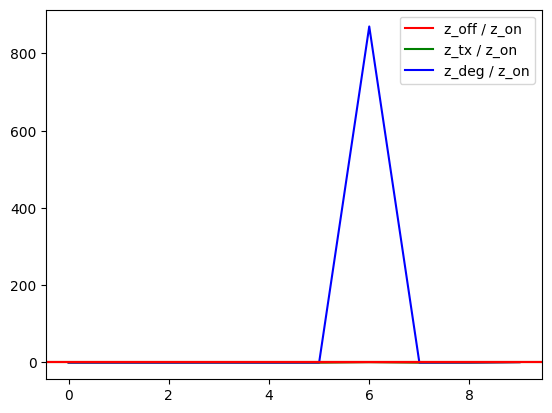

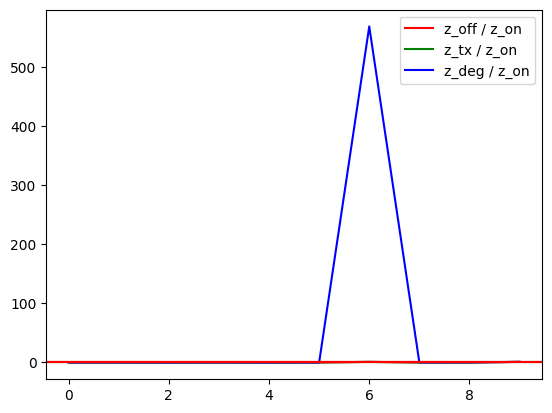

In [53]:
# only have optimization over k_tx, and only lower bound is bounded, so just compare z's in this optima
eps = 1e-5

z_on_lb = z_values["k_tx"]["z_on_lb"].reshape(-1, 1)
z_off_lb = z_values["k_tx"]["z_off_lb"].reshape(-1, 1)
z_tx_lb = z_values["k_tx"]["z_tx_lb"].reshape(-1, 1)
z_deg_lb = z_values["k_tx"]["z_deg_lb"].reshape(-1, 1)

# Z matrix
Z_lb = np.concatenate([z_on_lb, z_off_lb, z_tx_lb, z_deg_lb], axis=1)
print(f"Z = \n{Z_lb}")
print(f"Rank = {np.linalg.matrix_rank(Z_lb)}")

z_on_ub = z_values["k_tx"]["z_on_ub"].reshape(-1, 1)
z_off_ub = z_values["k_tx"]["z_off_ub"].reshape(-1, 1)
z_tx_ub = z_values["k_tx"]["z_tx_ub"].reshape(-1, 1)
z_deg_ub = z_values["k_tx"]["z_deg_ub"].reshape(-1, 1)

# Z matrix
Z_ub = np.concatenate([z_on_ub, z_off_ub, z_tx_ub, z_deg_ub], axis=1)
print(f"Z = \n{Z_ub}")
print(f"Rank = {np.linalg.matrix_rank(Z_ub)}")

def plotter(z_list):
    '''Plot elementwise ratios'''
    x = range(z_list[0].shape[0])
    plt.plot(x, z_list[1] / z_list[0], label="z_off / z_on", color="red")
    plt.plot(x, z_list[2] / z_list[0], label="z_tx / z_on", color="green")
    plt.plot(x, z_list[3] / z_list[0], label="z_deg / z_on", color="blue")
    plt.axhline(k_off / k_on, color="red")
    plt.axhline(k_tx / k_on, color="green")
    plt.axhline(k_deg / k_on, color="red")
    plt.legend()
    plt.show()

plotter([z_on_lb + eps, z_off_lb + eps, z_tx_lb + eps, z_deg_lb + eps])
plotter([z_on_ub + eps, z_off_ub + eps, z_tx_ub + eps, z_deg_ub + eps])

We see that the Z values at optima are not Rank 1, in fact are full rank, even with 3 fixed rates and further frechet bounds. 

There are many zero values so we add a small epsilon to consider the ratio between Z vectors (to see how 'far' from rank 1 we are) and see that while some elements are close, in general they are far from linearly dependent.

This is good motivation for non-linear programming, where we can work directly with p and k's, avoiding the z transformation which is likely causing problems.

# Non-Linear programming

So far have we have worked with linear programs, using the transformation $z_{r} = k_{r}p$ and writing everything in the z domain to ensure linear constraints (and objective). However, this leads to potentially weaker bounds as everything must be multiplied and simplified to ensure linearity.

Instead, we can work directly with the quadratic constraints, which involve $k_{r}p$ cross terms and ratios of parameters in frechet bounds. Using the Gurobi optimizer should still give a global minima / maxima solution for parameter bounds.

However, cvxpy only works with convex optimization problems, so we have to switch to directly using the Gurobi python API to form and solve these non-linear problems:

In [13]:
def gene_expression_NLP(params, N, intervals, print_solution=True):
    """
    Solve Non-Linear Programming problem to bound parameters

    Inputs:
    params: [k_on, k_off, k_tx, k_deg] either values that will be fixed, or "v"
        for variable to be bounded
    N: number of rows/equations of Qp = 0 to use in constraints
        must be even
    intervals: list of confidence intervals for at least N/2 + 1 marginal states
    """
	
	# number of marginals used
    M = int(N/2 + 1)

	# create Qr matrices:
	# create N + 2 x N + 2 square and drop last 2 rows, as have 2 upper diagonals
    Q_on = (np.diag([-1 if not x % 2 else 0 for x in range(0,N+2)],0) +
    		np.diag([1 if not x % 2 else 0 for x in range(0,N+1)],-1))[:-2, :]
    Q_off = (np.diag([-1 if x % 2 else 0 for x in range(0,N+2)],0) +
    		np.diag([1 if not x % 2 else 0 for x in range(0,N+1)],1))[:-2, :]
    Q_tx = (np.diag([-1 if x % 2 else 0 for x in range(0,N+2)],0) +
    		np.diag([1 if x % 2 else 0 for x in range(0,N)],-2))[:-2, :]
    Q_deg = (np.diag([-1 if x > 1 else 0 for x in range(0,N+2)],0) +
    		np.diag([1 for x in range(0,N)],2))[:-2, :]

    # bounds from CI, on marginal
    pl = [intr[0] for intr in intervals]
    pu = [intr[1] for intr in intervals]

    # define bounds
    pl = np.array(pl)[:M]
    pu = np.array(pu)[:M]

    # form doubled bounds
    pdl = np.repeat(pl,2)
    pdu = np.repeat(pu,2)

    # NOTE: need different cutoff: n p's <=> n/2 marginals
	
    # marginal = A @ p
    A = np.repeat(np.eye(M, dtype=int), repeats=2, axis=1)

	# Construct the problem.
    # Variables
    k1, k2, k3, k4 = params[0], params[1], params[2], params[3]
    if k1 == "v":
        k_on = cv.Variable()
    else:
        k_on = k1
    if k2 == "v":
        k_off = cv.Variable()
    else:
        k_off = k2
    if k3 == "v":
        k_tx = cv.Variable()
    else:
        k_tx = k3
    if k4 == "v":
        k_deg = cv.Variable()
    else:
        k_deg = k4
    # joint (full) stationary distribution
    p = cv.Variable(N + 2)

    # [k_on, k_off, k_on, k_off, ...]
    kv1 = np.array([0 if x % 2 else 1 for x in range(N + 2)])
    kv2 = np.array([1 if x % 2 else 0 for x in range(N + 2)])
    kv = k_on * kv1 + k_off * kv2

	# Constraints
    constraints = [
        # Qp = 0
        k_on * Q_on @ p + k_off * Q_off @ p + k_tx * Q_tx @ p + k_deg * Q_deg @ p == 0,
        # p_L <= A @ p <= p_U
        pl <= A @ p, A @ p <= pu,
        # 0 <= p <= 1
        0 <= p, p <= 1,
        # k_r >= 0
        k_on >= 0, k_off >= 0, k_tx >= 0, k_deg >= 0,
        # sum( p ) <= 1
        sum([p[x] for x in range(N + 2)]) <= 1,
        # frechet lower bounds (assume upper redundant)
        p <= np.ones(N + 2) - (1 / (k_on + k_off)) * kv,
        p >= pdl - (1 / (k_on + k_off)) * kv
		]
    
    # solutions
    solutions = {}

    # optimize for each variable
    if k1 == "v":
        prob_min = cv.Problem(cv.Minimize(k_on), constraints)
        prob_max = cv.Problem(cv.Maximize(k_on), constraints)
        prob_min.solve(solver=cv.GUROBI)
        prob_max.solve(solver=cv.GUROBI)
        solutions["k_on"] = [prob_min.value, prob_max.value, prob_min.status, prob_max.status]
    else:
        solutions["k_on"] = [k1]
    if k2 == "v":
        prob_min = cv.Problem(cv.Minimize(k_off), constraints)
        prob_max = cv.Problem(cv.Maximize(k_off), constraints)
        prob_min.solve(solver=cv.GUROBI)
        prob_max.solve(solver=cv.GUROBI)
        solutions["k_off"] = [prob_min.value, prob_max.value, prob_min.status, prob_max.status]
    else:
        solutions["k_off"] = [k2]
    if k3 == "v":
        prob_min = cv.Problem(cv.Minimize(k_tx), constraints)
        prob_max = cv.Problem(cv.Maximize(k_tx), constraints)
        prob_min.solve(solver=cv.GUROBI)
        prob_max.solve(solver=cv.GUROBI)
        solutions["k_tx"] = [prob_min.value, prob_max.value, prob_min.status, prob_max.status]
    else:
        solutions["k_tx"] = [k3]
    if k4 == "v":
        prob_min = cv.Problem(cv.Minimize(k_deg), constraints)
        prob_max = cv.Problem(cv.Maximize(k_deg), constraints)
        prob_min.solve(solver=cv.GUROBI)
        prob_max.solve(solver=cv.GUROBI)
        solutions["k_deg"] = [prob_min.value, prob_max.value, prob_min.status, prob_max.status]
    else:
        solutions["k_deg"] = [k4]

    if print_solution:
        for var in ["k_on", "k_off", "k_tx", "k_deg"]:
            try:
                print(f"\n{var} in ({solutions[var][0]}, {solutions[var][1]}) , status: {solutions[var][2]} , {solutions[var][3]}")
            except:
                print(f"\n{var} = {solutions[var][0]}")

    return solutions

In [12]:
intervals_NLP = bootstrap_marginal_optim(initial_state=(0, 0), params=[0.9, 0.1, 1, 1], n=1000, N=1000, tmax=100, plot=False, printing=True)

Simulation time: 5.173358678817749
Computation time: 0.014561653137207031
95% CI for m marginal p(0) is: (0.386, 0.446)
95% CI for m marginal p(1) is: (0.311, 0.367025)
95% CI for m marginal p(2) is: (0.151, 0.199)
95% CI for m marginal p(3) is: (0.043, 0.072)
95% CI for m marginal p(4) is: (0.006, 0.019)
95% CI for m marginal p(5) is: (0.0, 0.007)


In [13]:
solutions = gene_expression_NLP(params=[0.9, 0.1, "v", 1], N=2, intervals=intervals_NLP)

DCPError: Problem does not follow DCP rules. Specifically:
The following constraints are not DCP:
[[-0.90 0.00 0.00 0.00]
 [0.90 0.00 0.00 0.00]] @ var2 + [[0.00 0.10 0.00 0.00]
 [0.00 -0.10 0.00 0.00]] @ var2 + Promote(var1, (2, 4)) @ [[0.00 0.00 0.00 0.00]
 [0.00 -1.00 0.00 0.00]] @ var2 + [[0.00 0.00 1.00 0.00]
 [0.00 0.00 0.00 1.00]] @ var2 == 0.0 , because the following subexpressions are not:
|--  Promote(var1, (2, 4)) @ [[0.00 0.00 0.00 0.00]
 [0.00 -1.00 0.00 0.00]] @ var2

# Gurobi API

Implement the gene expression model using the Gurobi python API.

This is a non-convex model because of the $\sum_{r} k_{r} Q_{r} p = 0 $ constraint, but gurobi still aims for global optimality. This also allows the use of more complicated frechet bounds that could not be used before due to the linearity restriction.

In [54]:
import math, random
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import cvxpy as cv
import time
import gurobipy as gp
from gurobipy import GRB

In [58]:
def gene_expression_NLP(params, N, intervals, K=100, frechet_bounds=False, print_solution=True, printing=True):
    """
    Solve Non-Linear Programming problem to bound parameters

    Inputs:
    params: [k_on, k_off, k_tx, k_deg] either values that will be fixed, or "v"
        for variable to be bounded
    N: number of rows/equations of Qp = 0 to use in constraints
        must be even
    intervals: list of confidence intervals for at least N/2 + 1 marginal states
    K: upper bound on params (k's) for computational reasons
    frechet_bounds: bool to include additionally derived 'frechet' constraints
    print_solution: bool to print solution bounds
    printing: bool to print optimizer information
    """
	
	# number of marginals used
    M = int(N/2 + 1)

	# create Qr matrices:
	# create N + 2 x N + 2 square and drop last 2 rows, as have 2 upper diagonals
    Q_on = (np.diag([-1 if not x % 2 else 0 for x in range(0,N+2)],0) +
    		np.diag([1 if not x % 2 else 0 for x in range(0,N+1)],-1))[:-2, :]
    Q_off = (np.diag([-1 if x % 2 else 0 for x in range(0,N+2)],0) +
    		np.diag([1 if not x % 2 else 0 for x in range(0,N+1)],1))[:-2, :]
    Q_tx = (np.diag([-1 if x % 2 else 0 for x in range(0,N+2)],0) +
    		np.diag([1 if x % 2 else 0 for x in range(0,N)],-2))[:-2, :]
    diag = []
    off_diag = []
    m = 0
    for x in range(0, N + 2):
        diag.append(-m)
        if x > 1:
            off_diag.append(m)
        # every 2 entries, increase m by 1
        if x % 2:
            m += 1
    Q_deg = (np.diag(diag,0) + np.diag(off_diag,2))[:-2, :]

    # bounds from CI, on marginal
    pl = [intr[0] for intr in intervals]
    pu = [intr[1] for intr in intervals]

    # define bounds
    pl = np.array(pl)[:M]
    pu = np.array(pu)[:M]

    # form doubled bounds
    pdl = np.repeat(pl,2)
    pdu = np.repeat(pu,2)
	
    # marginal = A @ p
    A = np.repeat(np.eye(M, dtype=int), repeats=2, axis=1)

    # create model
    m = gp.Model("gene_exp")

    # set options
    if not printing:
        m.Params.LogToConsole = 0

    # add variable p in [0, 1]
    p = m.addMVar(shape=N + 2, vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)

    # initialize fixed / variable rates, constrain to [0, K] for computational reasons
    if params[0] == "v":
        k_on = m.addVar(vtype=GRB.CONTINUOUS, name="k_on", lb=0, ub=K)
    else:
        k_on = params[0]
    if params[1] == "v":
        k_off = m.addVar(vtype=GRB.CONTINUOUS, name="k_off", lb=0, ub=K)
    else:
        k_off = params[1]
    if params[2] == "v":
        k_tx = m.addVar(vtype=GRB.CONTINUOUS, name="k_tx", lb=0, ub=K)
    else:
        k_tx = params[2]
    if params[3] == "v":
        k_deg = m.addVar(vtype=GRB.CONTINUOUS, name="k_deg", lb=0, ub=K)
    else:
        k_deg = params[3]

    # Constraints:
    # Stationary condition: Qp = 0
    m.addConstr(k_on*(Q_on @ p) + k_off*(Q_off @ p) + k_tx*(Q_tx @ p) + k_deg*(Q_deg @ p) == 0, name="Qp=0")
    # marginal bounds: p_L <= A @ p <= p_U
    m.addConstr(pl <= A @ p, name="Marginal lb")
    m.addConstr(A @ p <= pu, name="Marginal ub" )
    # truncated joint dist: sum(p) <= 1
    m.addConstr(p.sum() <= 1, name="Joint dist")

    if frechet_bounds:
        # frechet lower bounds (assume upper redundant)
        # [k_on, k_off, k_on, k_off, ...]
        kv1 = np.array([0 if x % 2 else 1 for x in range(N + 2)])
        kv2 = np.array([1 if x % 2 else 0 for x in range(N + 2)])
        kv = k_on * kv1 + k_off * kv2
        # m.addConstr(p <= np.ones(N + 2) - (1 / (k_on + k_off)) * kv)
        # m.addConstr(p >= pdl - (1 / (k_on + k_off)) * kv)
        m.addConstr((k_on + k_off) * p <= (k_on + k_off) * np.ones(N + 2) - kv)
        m.addConstr((k_on + k_off) * p >= (k_on + k_off) * pdl - kv)

    # objective
    m.setObjective(k_tx, GRB.MINIMIZE)

    try:
        # optimize (solve)
        m.optimize()
        # record
        min_val = m.ObjVal
    except:
        # record as infeasible/unbounded
        min_val = None

    # reset
    m.reset()

    # change objective
    m.setObjective(k_tx, GRB.MAXIMIZE)

    try:
        # re-optimize (re-solve)
        m.optimize()
        # record
        max_val = m.ObjVal
    except:
        # record as infeasible/unbounded
        max_val = None
    
    # print
    if print_solution: print(f"k_tx in ({min_val}, {max_val})")

    return min_val, max_val

In [59]:
def gene_expression_NLP_update(params, N, intervals, K=100, frechet_bounds=False, print_solution=True, printing=True):
    """
    Solve Non-Linear Programming problem to bound parameters

    Inputs:
    params: [k_on, k_off, k_tx, k_deg] either values that will be fixed, or "v"
        for variable to be bounded
    N: number of rows/equations of Qp = 0 to use in constraints
        must be even
    intervals: list of confidence intervals for at least N/2 + 1 marginal states
    K: upper bound on params (k's) for computational reasons
    frechet_bounds: bool to include additionally derived 'frechet' constraints
    print_solution: bool to print solution bounds
    printing: bool to print optimizer information
    """
	
	# number of marginals used
    M = int(N/2 + 1)

	# create Qr matrices:
	# create N + 2 x N + 2 square and drop last 2 rows, as have 2 upper diagonals
    Q_on = (np.diag([-1 if not x % 2 else 0 for x in range(0,N+2)],0) +
    		np.diag([1 if not x % 2 else 0 for x in range(0,N+1)],-1))[:-2, :]
    Q_off = (np.diag([-1 if x % 2 else 0 for x in range(0,N+2)],0) +
    		np.diag([1 if not x % 2 else 0 for x in range(0,N+1)],1))[:-2, :]
    Q_tx = (np.diag([-1 if x % 2 else 0 for x in range(0,N+2)],0) +
    		np.diag([1 if x % 2 else 0 for x in range(0,N)],-2))[:-2, :]
    diag = []
    off_diag = []
    m = 0
    for x in range(0, N + 2):
        diag.append(-m)
        if x > 1:
            off_diag.append(m)
        # every 2 entries, increase m by 1
        if x % 2:
            m += 1
    Q_deg = (np.diag(diag,0) + np.diag(off_diag,2))[:-2, :]

    # bounds from CI, on marginal
    pl = [intr[0] for intr in intervals]
    pu = [intr[1] for intr in intervals]

    # define bounds
    pl = np.array(pl)[:M]
    pu = np.array(pu)[:M]

    # form doubled bounds
    pdl = np.repeat(pl,2)
    pdu = np.repeat(pu,2)
	
    # marginal = A @ p
    A = np.repeat(np.eye(M, dtype=int), repeats=2, axis=1)

    # create model
    m = gp.Model("gene_exp")

    # set options
    if not printing:
        m.Params.LogToConsole = 0

    # add variable p in [0, 1]
    p = m.addMVar(shape=N + 2, vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)

    # initialize fixed / variable rates, constrain to [0, K] for computational reasons
    if params[0] == "v":
        k_on = m.addVar(vtype=GRB.CONTINUOUS, name="k_on", lb=0, ub=K)
    else:
        k_on = params[0]
    if params[1] == "v":
        k_off = m.addVar(vtype=GRB.CONTINUOUS, name="k_off", lb=0, ub=K)
    else:
        k_off = params[1]
    if params[2] == "v":
        k_tx = m.addVar(vtype=GRB.CONTINUOUS, name="k_tx", lb=0, ub=K)
    else:
        k_tx = params[2]
    if params[3] == "v":
        k_deg = m.addVar(vtype=GRB.CONTINUOUS, name="k_deg", lb=0, ub=K)
    else:
        k_deg = params[3]

    # Constraints:
    # Stationary condition: Qp = 0
    m.addConstr(k_on*(Q_on @ p) + k_off*(Q_off @ p) + k_tx*(Q_tx @ p) + k_deg*(Q_deg @ p) == 0, name="Qp=0")
    # marginal bounds: p_L <= A @ p <= p_U
    m.addConstr(pl <= A @ p, name="Marginal lb")
    m.addConstr(A @ p <= pu, name="Marginal ub" )
    # truncated joint dist: sum(p) <= 1
    m.addConstr(p.sum() <= 1, name="Joint dist")

    if frechet_bounds:
        # frechet bound vector
        kv_off = np.array([0 if x % 2 else 1 for x in range(N + 2)])
        kv_on = np.array([1 if x % 2 else 0 for x in range(N + 2)])
        kv = k_off * kv_off + k_on * kv_on
        # frechet bound
        m.addConstr((k_on + k_off) * p <= kv)

    # objective
    m.setObjective(k_tx, GRB.MINIMIZE)

    try:
        # optimize (solve)
        m.optimize()
        # record
        min_val = m.ObjVal
    except:
        # record as infeasible/unbounded
        min_val = None

    # reset
    m.reset()

    # change objective
    m.setObjective(k_tx, GRB.MAXIMIZE)

    try:
        # re-optimize (re-solve)
        m.optimize()
        # record
        max_val = m.ObjVal
    except:
        # record as infeasible/unbounded
        max_val = None
    
    # print
    if print_solution: print(f"k_tx in ({min_val}, {max_val})")

    return min_val, max_val

## Results

In [56]:
intervals_NLP = bootstrap_approx(initial_state=(0, 0), params=[0.9, 0.1, 1, 1], n=5000, N=5000, tmax=100, ts=10, plot=False, printing=True)

95% CI for m marginal p(0) is: (0.4088, 0.436)
95% CI for m marginal p(1) is: (0.3316, 0.35820499999999994)
95% CI for m marginal p(2) is: (0.1536, 0.1744)
95% CI for m marginal p(3) is: (0.0466, 0.059)
95% CI for m marginal p(4) is: (0.0092, 0.0154)
95% CI for m marginal p(5) is: (0.0012, 0.0038)
95% CI for m marginal p(6) is: (0.0002, 0.002)
95% CI for m marginal p(7) is: (0.0, 0.001)


In [62]:
# 1 variable fixed: good lower bound even for low N, starting to get upper bound for large N
lb, ub = gene_expression_NLP(params=["v", "v", "v", 1], N=2, intervals=intervals_NLP, frechet_bounds=False, printing=False)
lb, ub = gene_expression_NLP(params=["v", "v", "v", 1], N=8, intervals=intervals_NLP, frechet_bounds=False, printing=False)
print(10*"-")
lb, ub = gene_expression_NLP_update(params=["v", "v", "v", 1], N=2, intervals=intervals_NLP, frechet_bounds=False, printing=False)
lb, ub = gene_expression_NLP_update(params=["v", "v", "v", 1], N=8, intervals=intervals_NLP, frechet_bounds=False, printing=False)
print("\nfrechet bounds\n")
lb, ub = gene_expression_NLP(params=["v", "v", "v", 1], N=2, intervals=intervals_NLP, frechet_bounds=True, printing=False)
lb, ub = gene_expression_NLP(params=["v", "v", "v", 1], N=8, intervals=intervals_NLP, frechet_bounds=True, printing=False)
print(10*"-")
lb, ub = gene_expression_NLP_update(params=["v", "v", "v", 1], N=2, intervals=intervals_NLP, frechet_bounds=True, printing=False)
lb, ub = gene_expression_NLP_update(params=["v", "v", "v", 1], N=8, intervals=intervals_NLP, frechet_bounds=True, printing=False)

k_tx in (0.7605504689092281, 100.0)
k_tx in (0.8834923006254883, 16.98170986515126)
----------
k_tx in (0.7605504689092281, 100.0)
k_tx in (0.8834923006254883, 16.98170986515126)

frechet bounds

k_tx in (0.7605504735877598, 100.0)
k_tx in (0.8834923145803147, 16.981709863375432)
----------
k_tx in (0.7605504719333729, 100.0)
k_tx in (0.8834923045745007, 16.981709863339464)


In [63]:
# the size of the upper bound changes based on the value of K, but there is clearly some information that can inform an upper bound
# that is better than a pre-set maximum value
lb, ub = gene_expression_NLP(params=["v", "v", "v", 1], N=8, K=1000, intervals=intervals_NLP, frechet_bounds=True, printing=False)

k_tx in (0.8834916783132953, 149.68949872433473)


In [69]:
# 3 variable fixed: very good lower AND upper bounds even for low N, improving for higher N
lb, ub = gene_expression_NLP(params=[0.9, 0.1, "v", 1], N=2, intervals=intervals_NLP, frechet_bounds=False, printing=False)
lb, ub = gene_expression_NLP(params=[0.9, 0.1, "v", 1], N=8, intervals=intervals_NLP, frechet_bounds=False, printing=False)
print(10*"-")
lb, ub = gene_expression_NLP_update(params=[0.9, 0.1, "v", 1], N=2, intervals=intervals_NLP, frechet_bounds=False, printing=False)
lb, ub = gene_expression_NLP_update(params=[0.9, 0.1, "v", 1], N=8, intervals=intervals_NLP, frechet_bounds=False, printing=False)
print("\nfrechet bounds\n")
lb, ub = gene_expression_NLP(params=[0.9, 0.1, "v", 1], N=2, intervals=intervals_NLP, frechet_bounds=True, printing=False)
lb, ub = gene_expression_NLP(params=[0.9, 0.1, "v", 1], N=8, intervals=intervals_NLP, frechet_bounds=True, printing=False)
print(10*"-")
lb, ub = gene_expression_NLP_update(params=[0.9, 0.1, "v", 1], N=2, intervals=intervals_NLP, frechet_bounds=True, printing=False)
lb, ub = gene_expression_NLP_update(params=[0.9, 0.1, "v", 1], N=8, intervals=intervals_NLP, frechet_bounds=True, printing=False)

k_tx in (0.8450560702074548, 36.87133298270667)
k_tx in (0.9467169035391247, 1.0695955854936785)
----------
k_tx in (0.8450560702074548, 36.87133298270667)
k_tx in (0.9467169035391247, 1.0695955854936785)

frechet bounds

k_tx in (0.8450560702060904, 1.1599902767198198)
k_tx in (0.9467169035391297, 1.069595585493656)
----------
k_tx in (0.8450560702060904, 1.1599902767198205)
k_tx in (0.946716903539125, 1.0695955854936792)


In [67]:
# 1 variable fixed: only a lower bound (slightly worse than NLP), improving with N
solutions = gene_expression_LP_update(params=["v", "v", "v", 1], N=2, intervals=intervals_NLP, frechet_bounds=True)
print(f"\n{10 * '-'} \n")
solutions = gene_expression_LP_update(params=["v", "v", "v", 1], N=8, intervals=intervals_NLP, frechet_bounds=True)


k_on in (0.0, None) , status: optimal , infeasible_or_unbounded

k_off in (0.0, None) , status: optimal , infeasible_or_unbounded

k_tx in (0.7605504587155963, None) , status: optimal , infeasible_or_unbounded

k_deg = 1

---------- 


k_on in (0.0, None) , status: optimal , infeasible_or_unbounded

k_off in (0.0, None) , status: optimal , infeasible_or_unbounded

k_tx in (0.8576094694378917, None) , status: optimal , infeasible_or_unbounded

k_deg = 1


In [68]:
# 3 variables fixed: still only a lower bound (for these parameters) that improves with N
# NOTE: does not improve over 1 variable fixed
solutions = gene_expression_LP_update(params=[0.9, 0.1, "v", 1], N=2, intervals=intervals_NLP, frechet_bounds=True)
print(f"\n{10 * '-'} \n")
solutions = gene_expression_LP_update(params=[0.9, 0.1, "v", 1], N=8, intervals=intervals_NLP, frechet_bounds=True)


k_on = 0.9

k_off = 0.1

k_tx in (0.7605504587155963, None) , status: optimal , infeasible_or_unbounded

k_deg = 1

---------- 


k_on = 0.9

k_off = 0.1

k_tx in (0.8576094694378917, None) , status: optimal , infeasible_or_unbounded

k_deg = 1


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\problems\problem.py:1409: UserWarning: 
    The problem is either infeasible or unbounded, but the solver
    cannot tell which. Disable any solver-specific presolve methods
    and re-solve to determine the precise problem status.

    For GUROBI and CPLEX you can automatically perform this re-solve
    with the keyword argument prob.solve(reoptimize=True, ...).
    
  warnings.warn(INF_OR_UNB_MESSAGE)


#### 1 variable fixed

For just 1 variable fixed, e.g. $k_{deg} = 1$ for identifiability, the NLP produces good lower bounds even for small N = 2, improving for larger N = 8 and also starting to produce an **upper** bound (although the size of this upper bound depends on the choice of K, it shows there is some information to reduce the bound from this set maximum value). Compared to the LP, the NLP lower bound is better.

#### 3 variables fixed

Fixing $k_{on}$ and $k_{off}$, the NLP bounds improve dramatically, producing slightly better lower bounds and a very good **upper** bound on $k_{tx}$ even for N = 2 which become very narrow for larger N = 8. Compared to the LP whose bounds do not improve when these variables are fixed, still having no upper bound (at least for these parameter values).

In general we see that the NLP can produce good bounds, and is a significant improvement over the LP which is highly parameter dependent, especially for upper bounds.

## Effect of N

We now investigate how NLP, and LP, bounds change with increasing N: number of CI bounds included in the optimization. Additionally we consider different parameter situations, both in terms of which variables are fixed, and the parameter values used

In [70]:
def plot_comparison_single(N_max, intervals, params, frechet, true_value, K=10):
    '''
    N_max: maximum number of equations to use
    intervals: marginal bounds used (must be able to bound at least N_max joints)
    params: parameters used to solve (variable: "v" or fixed: value)
    frechet: bool if frechet bounds are used
    true_value: true value of k_tx
    '''
    lbs_NLP, ubs_NLP = [], []
    lbs_LP, ubs_LP = [], []
    Ns = [n for n in range(2, N_max, 2)]
    for N in Ns:
        lb, ub = gene_expression_NLP_update(params=params, N=N, K=K, intervals=intervals_plot, frechet_bounds=frechet, printing=False, print_solution=False)
        solution = gene_expression_LP_update(params=params, N=N, intervals=intervals_plot, frechet_bounds=frechet, print_solution=False)
        lbs_LP.append(solution['k_tx'][0])
        ubs_LP.append(solution['k_tx'][1])
        lbs_NLP.append(lb)
        ubs_NLP.append(ub)
    plt.plot(Ns, lbs_NLP, color="blue", label="NLP bounds")
    plt.plot(Ns, ubs_NLP, color="blue")
    plt.plot(Ns, lbs_LP, color="orange", label="LP bounds")
    plt.plot(Ns, ubs_LP, color="orange")
    plt.axhline(k_tx, color="red", label=f"k_tx = {true_value}")
    plt.title("Solution bounds on k_tx against equations used")
    plt.xlabel("N (number of equations used)")
    plt.ylabel("Solution bounds on k_tx")
    plt.legend()
    plt.show()

In [120]:
def plot_comparison(N_max, intervals, params, K=10):
    '''
    N_max: maximum number of equations to use
    intervals: marginal bounds used (must be able to bound at least N_max joints)
    params: dict of true parameter values
    K: max of k's used to solve
    '''
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    params_one_fixed = ["v", "v", "v", params['k_deg']]
    params_three_fixed = [params['k_on'], params['k_off'], "v", params['k_deg']]
    # 1 variable / variables fixed
    for i, params_used in enumerate([params_one_fixed, params_three_fixed]):
        # frechet bounds off / on
        for j, frechet in enumerate([False, True]):
            lbs_NLP, ubs_NLP = [], []
            lbs_LP, ubs_LP = [], []
            Ns = [n for n in range(2, N_max, 2)]
            for N in Ns:
                if i == 1 and j == 1:
                    frechet_further = True
                else:
                    frechet_further = False
                lb, ub = gene_expression_NLP_update(params=params_used, N=N, K=K, intervals=intervals, frechet_bounds=frechet, printing=False, print_solution=False)
                solution = gene_expression_LP_update(params=params_used, N=N, intervals=intervals, frechet_bounds=frechet, frechet_bounds_further=frechet_further, print_solution=False)
                lbs_LP.append(solution['k_tx'][0])
                ubs_LP.append(solution['k_tx'][1])
                lbs_NLP.append(lb)
                ubs_NLP.append(ub)
            # NLP
            axs[i, j].plot(Ns, lbs_NLP, color="blue", label="NLP bounds")
            axs[i, j].plot(Ns, ubs_NLP, color="blue")
            axs[i, j].scatter(Ns, lbs_NLP, color="blue")
            axs[i, j].scatter(Ns, ubs_NLP, color="blue")
            # LP
            axs[i, j].plot(Ns, lbs_LP, color="orange", label="LP bounds")
            axs[i, j].plot(Ns, ubs_LP, color="orange")
            axs[i, j].scatter(Ns, lbs_LP, color="orange")
            axs[i, j].scatter(Ns, ubs_LP, color="orange")
            axs[i, j].axhline(params['k_tx'], color="red", label=f"True k_tx = {params['k_tx']}")
            axs[i, j].set_title(f"{['1 variable','3 variables'][i]} fixed{', fréchet bounds' if frechet else ''}")
            axs[i, j].set_xlabel("N (number of equations used)")
            axs[i, j].set_ylabel("Solution bounds on k_tx")
            if i == 0 or not j:
                axs[i, j].legend()
    plt.suptitle("Solution bounds on k_tx against equations used")
    plt.show()

In [84]:
# parameters
params_1 = {'k_on': 2, 'k_off': 1, 'k_tx': 2, 'k_deg': 1}

# intervals
print(f"Intervals: \n")
intervals_1 = bootstrap_approx(initial_state=(0, 0), params=list(params_1.values()), n=5000, N=5000, tmax=100, ts=10, plot=False, printing=True)

Intervals: 

95% CI for m marginal p(0) is: (0.2906, 0.316)
95% CI for m marginal p(1) is: (0.3192, 0.3458)
95% CI for m marginal p(2) is: (0.199595, 0.222)
95% CI for m marginal p(3) is: (0.0914, 0.1078)
95% CI for m marginal p(4) is: (0.0346, 0.0452)
95% CI for m marginal p(5) is: (0.0076, 0.0132)
95% CI for m marginal p(6) is: (0.0014, 0.0044)
95% CI for m marginal p(7) is: (0.0002, 0.0016)
95% CI for m marginal p(8) is: (0.0, 0.001)


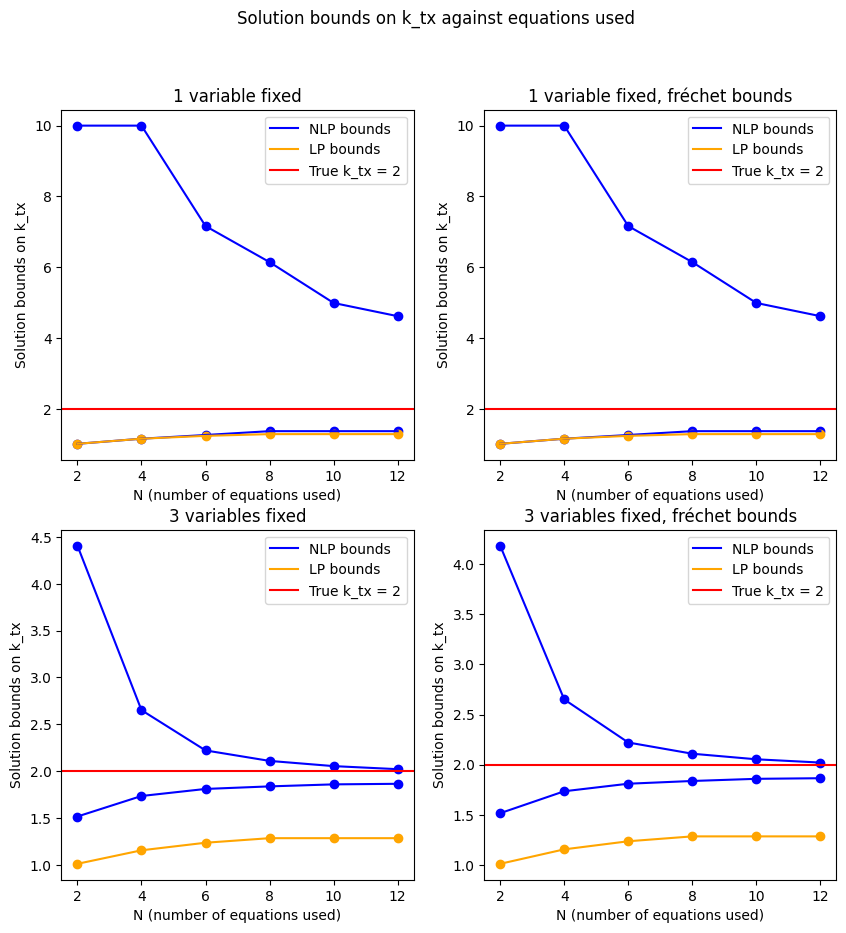

In [93]:
plot_comparison(14, intervals_1, params_1)

In [113]:
# parameters
params_2 = {'k_on': 5, 'k_off': 1, 'k_tx': 1, 'k_deg': 1}

# intervals
print(f"\nIntervals: \n")
intervals_2 = bootstrap_approx(initial_state=(0, 0), params=list(params_2.values()), n=5000, N=5000, tmax=100, ts=10, plot=False, printing=True)


Intervals: 

95% CI for m marginal p(0) is: (0.4228, 0.4504)
95% CI for m marginal p(1) is: (0.3436, 0.3698)
95% CI for m marginal p(2) is: (0.1394, 0.1594)
95% CI for m marginal p(3) is: (0.0398, 0.0514)
95% CI for m marginal p(4) is: (0.008, 0.0138)
95% CI for m marginal p(5) is: (0.0002, 0.0018)
95% CI for m marginal p(6) is: (0.0, 0.0006)
95% CI for m marginal p(7) is: (0.0, 0.0006)


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\problems\problem.py:1409: UserWarning: 
    The problem is either infeasible or unbounded, but the solver
    cannot tell which. Disable any solver-specific presolve methods
    and re-solve to determine the precise problem status.

    For GUROBI and CPLEX you can automatically perform this re-solve
    with the keyword argument prob.solve(reoptimize=True, ...).
    
  warnings.warn(INF_OR_UNB_MESSAGE)


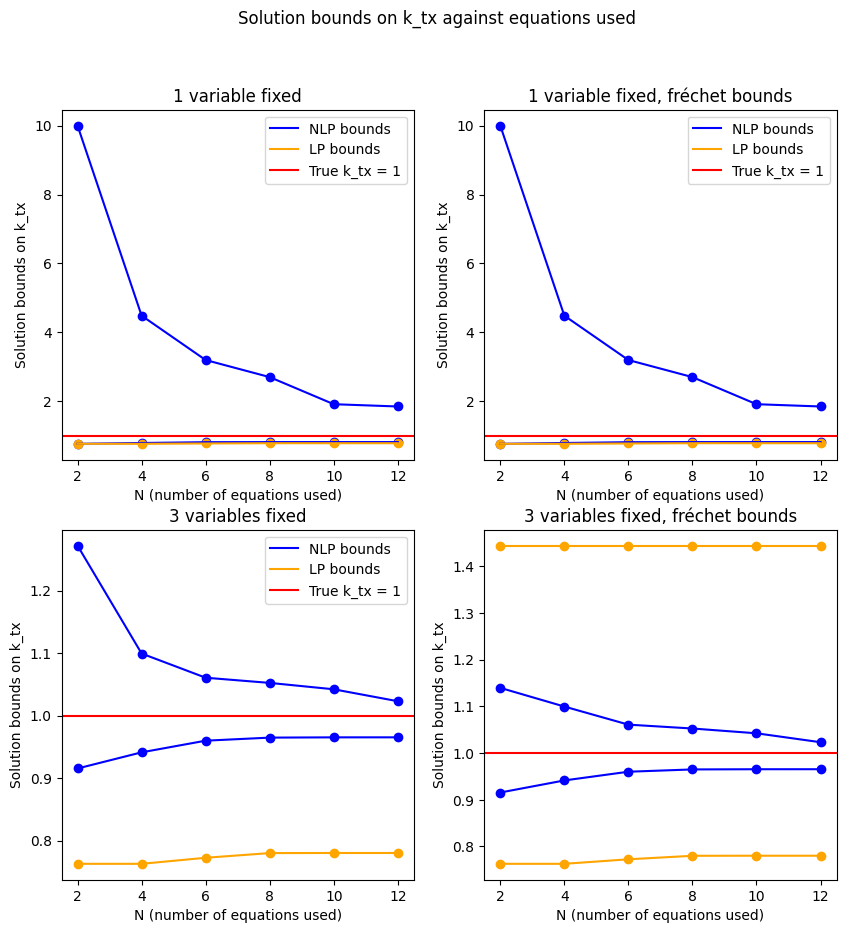

In [121]:
plot_comparison(14, intervals_2, params_2, K=10)

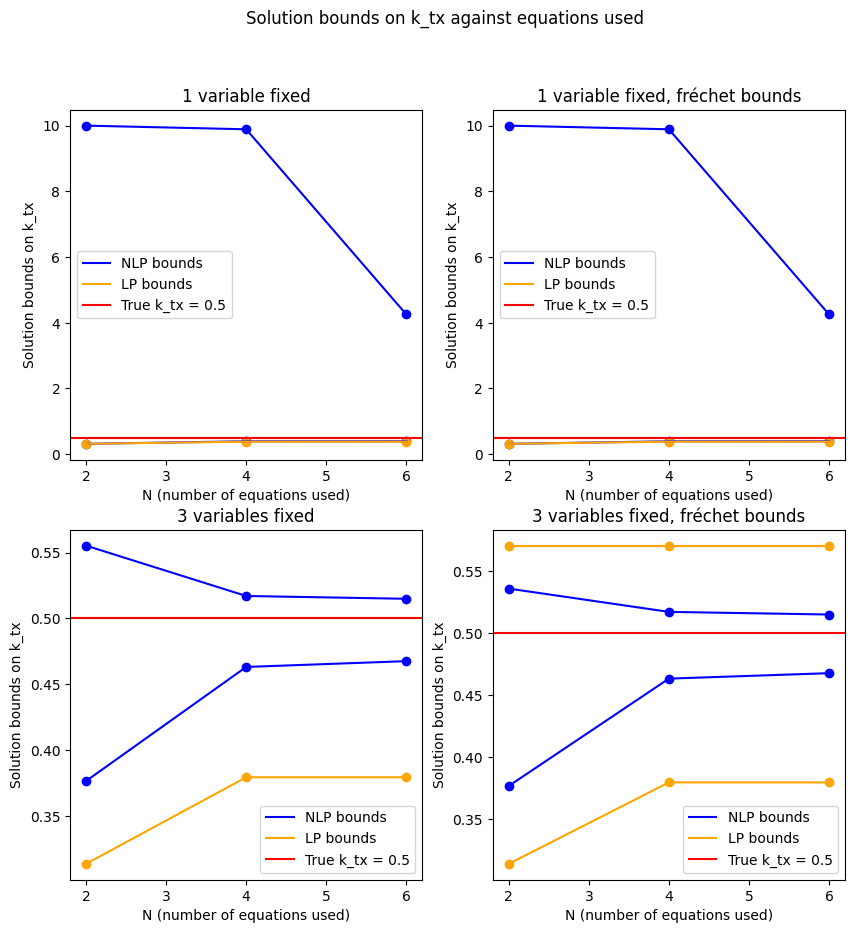

In [100]:
plot_comparison(8, intervals_2, params_2, K=10)

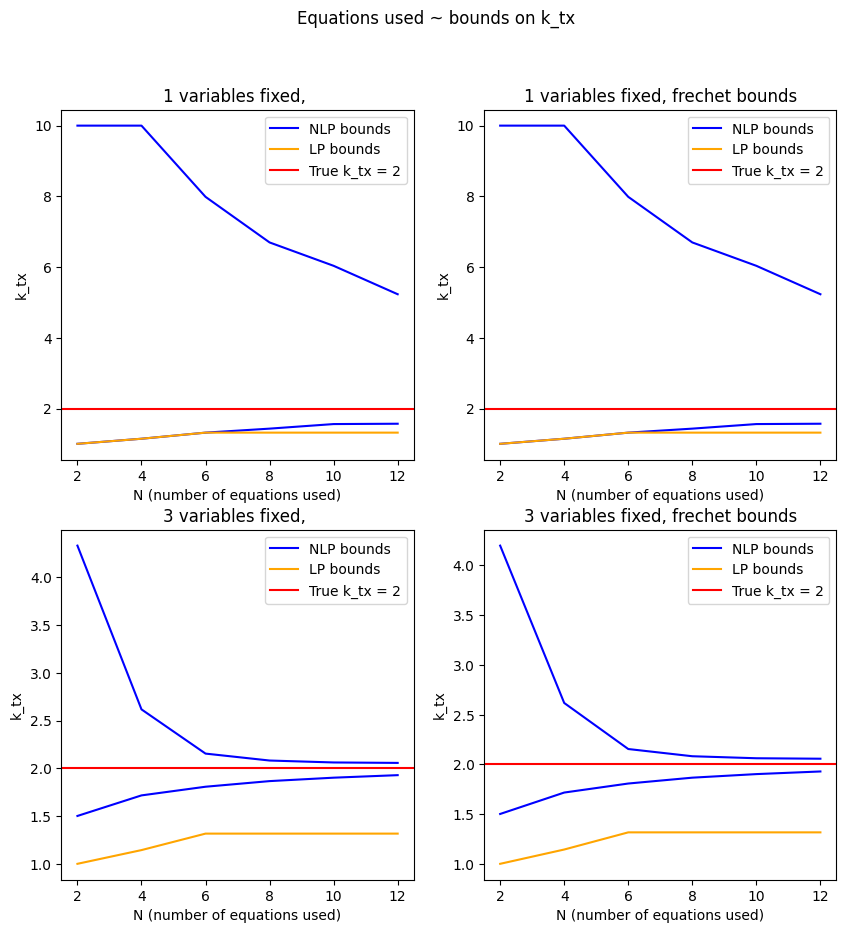

In [120]:
plot_comparison(14, intervals_1, params_1)

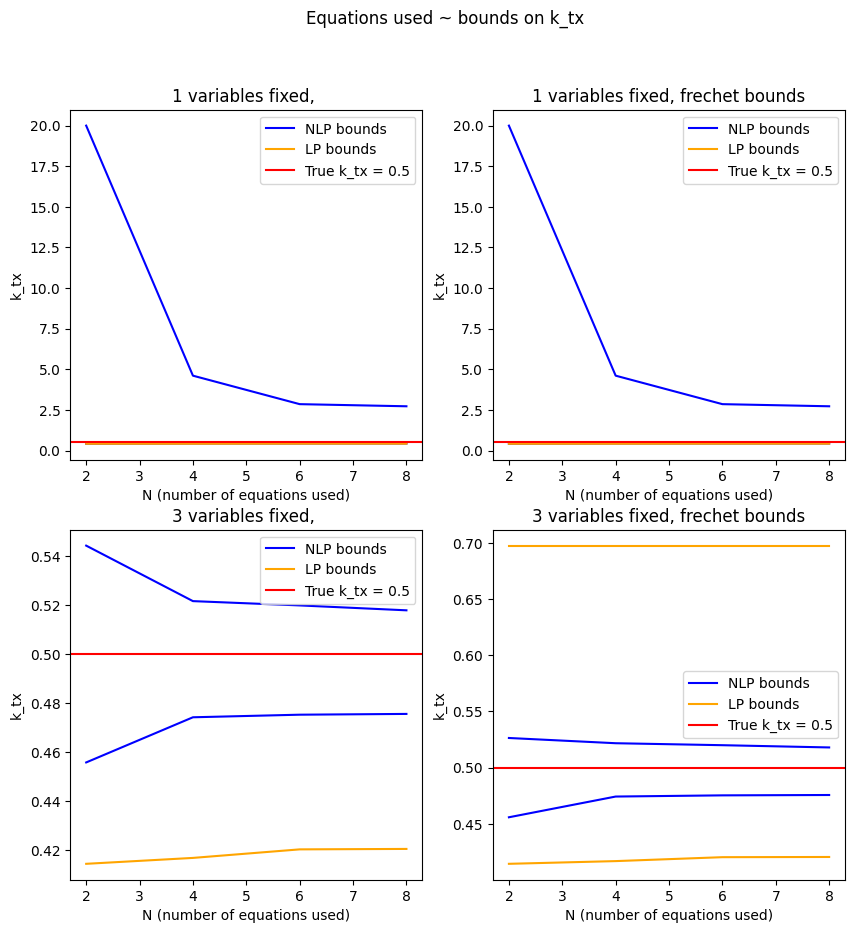

In [124]:
plot_comparison(10, intervals_2, params_2, K=20)

## Computation time

In [122]:
intervals = bootstrap_approx(initial_state=(0, 0), params=[5, 1, 5, 1], n=5000, N=5000, tmax=100, ts=10, plot=False, printing=True)

95% CI for m marginal p(0) is: (0.0174, 0.0254)
95% CI for m marginal p(1) is: (0.0708, 0.0858)
95% CI for m marginal p(2) is: (0.133, 0.1524)
95% CI for m marginal p(3) is: (0.1588, 0.17960499999999993)
95% CI for m marginal p(4) is: (0.175195, 0.1964)
95% CI for m marginal p(5) is: (0.1346, 0.1538)
95% CI for m marginal p(6) is: (0.1024, 0.12)
95% CI for m marginal p(7) is: (0.06579499999999999, 0.08)
95% CI for m marginal p(8) is: (0.033595, 0.044)
95% CI for m marginal p(9) is: (0.017, 0.025)
95% CI for m marginal p(10) is: (0.0068, 0.0122)
95% CI for m marginal p(11) is: (0.0016, 0.0046)
95% CI for m marginal p(12) is: (0.0004, 0.0022)
95% CI for m marginal p(13) is: (0.0002, 0.0016)
95% CI for m marginal p(14) is: (0.0, 0.001)


In [123]:
lb, ub = gene_expression_NLP_update(params=["v", "v", "v", 1], N=24, K=100, intervals=intervals, frechet_bounds=True, printing=False)

k_tx in (4.366767314256938, 28.177988078656007)


In [124]:
solutions = gene_expression_LP_update(params=["v", "v", "v", 1], N=24, intervals=intervals, frechet_bounds=True)


k_on in (0.0, None) , status: optimal , infeasible_or_unbounded

k_off in (0.0, None) , status: optimal , infeasible_or_unbounded

k_tx in (3.99479843953186, None) , status: optimal , infeasible_or_unbounded

k_deg = 1


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\problems\problem.py:1409: UserWarning: 
    The problem is either infeasible or unbounded, but the solver
    cannot tell which. Disable any solver-specific presolve methods
    and re-solve to determine the precise problem status.

    For GUROBI and CPLEX you can automatically perform this re-solve
    with the keyword argument prob.solve(reoptimize=True, ...).
    
  warnings.warn(INF_OR_UNB_MESSAGE)


For very large problems, the LP is faster than the NLP ~1 second vs ~10 seconds. However, for the vast majority of problems they are both very fast.

## Test Birth-Death case

Using $ k_{on} = 1 $ and $ k_{off} = 0 $ ensures the gene is always on and so the number of molecules of M follows a simple birth death reaction. The m marginal of the stationary distribution is then Poi($ k_{tx} / k_{deg}$) (and p(m, 0) = 0, p(m) = p(m, 1)).

Simulating sample paths and bootstrapping we can compare against the true marginal values to verify the CI accuracy, seeing when infeasibility of the LP / NLP occurs due to CI bounds that do not contain their true values:

In [160]:
# params
k_on = 1
k_off = 0
k_tx = 2
k_deg = 1

# intervals
intervals_BD = bootstrap_approx((0,0), [k_on, k_off, k_tx, k_deg], n=500, N=500, tmax=100, ts=10, plot=False, printing=True)

95% CI for m marginal p(0) is: (0.12095, 0.18104999999999996)
95% CI for m marginal p(1) is: (0.22295, 0.30704999999999993)
95% CI for m marginal p(2) is: (0.27, 0.3490499999999999)
95% CI for m marginal p(3) is: (0.108, 0.17104999999999995)
95% CI for m marginal p(4) is: (0.064, 0.114)
95% CI for m marginal p(5) is: (0.02, 0.05304999999999995)
95% CI for m marginal p(6) is: (0.0, 0.014)
95% CI for m marginal p(7) is: (0.0, 0.014)
95% CI for m marginal p(8) is: (0.0, 0.0)
95% CI for m marginal p(9) is: (0.0, 0.006)


In [161]:
# number of marginal CIs
M = len(intervals_BD)

# true stationary distribution
true_p = [(k_tx / k_deg)**k * math.exp(-k_tx / k_deg) / math.factorial(k) for k in range(M + 1)]
for i in range(M):
    valid = False
    if intervals_BD[i][0] <= true_p[i] and intervals_BD[i][1] >= true_p[i]:
        valid = True
    print(f"True value of m marginal p({i}) is: {true_p[i]} , CI ({intervals_BD[i][0]}, {intervals_BD[i][1]}) is {valid}")

True value of m marginal p(0) is: 0.1353352832366127 , CI (0.12095, 0.18104999999999996) is True
True value of m marginal p(1) is: 0.2706705664732254 , CI (0.22295, 0.30704999999999993) is True
True value of m marginal p(2) is: 0.2706705664732254 , CI (0.27, 0.3490499999999999) is True
True value of m marginal p(3) is: 0.1804470443154836 , CI (0.108, 0.17104999999999995) is False
True value of m marginal p(4) is: 0.0902235221577418 , CI (0.064, 0.114) is True
True value of m marginal p(5) is: 0.03608940886309672 , CI (0.02, 0.05304999999999995) is True
True value of m marginal p(6) is: 0.012029802954365574 , CI (0.0, 0.014) is True
True value of m marginal p(7) is: 0.0034370865583901638 , CI (0.0, 0.014) is True
True value of m marginal p(8) is: 0.0008592716395975409 , CI (0.0, 0.0) is False
True value of m marginal p(9) is: 0.00019094925324389798 , CI (0.0, 0.006) is True


In [162]:
for N in range(2, 18, 2):
    lb, ub = gene_expression_NLP(params=["v", "v", "v", 1], N=N, intervals=intervals_BD, frechet_bounds=False, printing=False)
    #solutions = gene_expression_LP_optim(params=["v", "v", "v", 1], N=N, intervals=intervals_BD, frechet_bounds=True)

k_tx in (1.231427792291994, 100.0)
k_tx in (1.7586712377481226, 100.0)
k_tx in (1.7586712341846344, 19.01861839805546)
k_tx in (1.7586712351486287, 14.21811153791087)
k_tx in (1.7590739533913893, 6.050932801685825)
k_tx in (1.8074455359757249, 2.9773350952873203)
k_tx in (1.8598846279944268, 2.058828440332318)
k_tx in (None, None)
